In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

from mxgpy.util import positive_transform_reverse_numpy

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [2]:
import helper
import numpy as np

 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


# 1. No control signal

In [3]:
train_motions = ['17', '18', '19', '20']
test_motions = ['21', '22', '23', '24']
subject = '35'
m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=2, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_list, y_train_mean_list, y_train_std_list = [],[],[]
for item in y_train:
    out, mean, std = helper.normalise_data(item)
    y_train_list.append(out)
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
    
    
y_test_list, y_test_mean_list, y_test_std_list = [], [], []
for item in y_test:
    out, mean, std = helper.normalise_data(item)
    y_test_list.append(out)
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    

In [4]:
[y_train[0][i].shape for i in range(4)]

[(84, 6), (88, 6), (80, 6), (82, 6)]

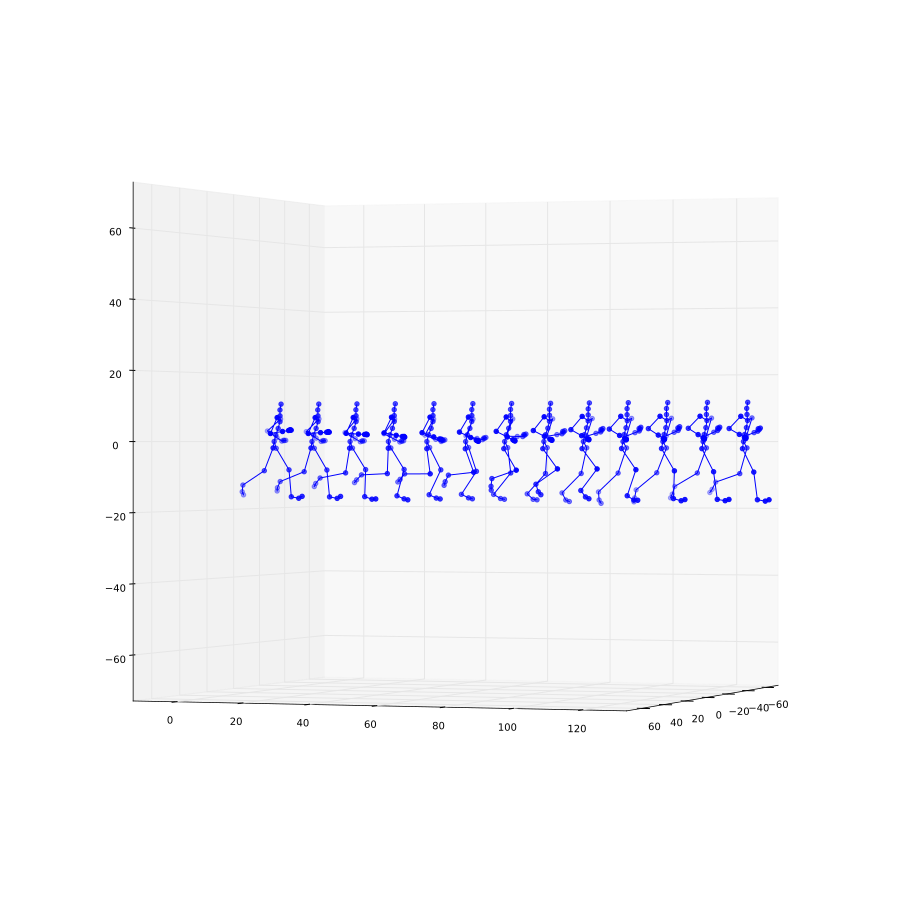

In [11]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)
y = helper.reshape(y_test_list)

helper.save_trail(y[1][:,3:], mean_list[1][3:], std_list[1][3:], m1['skel'], "original")

### Model Training

In [6]:
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

for idx, y_train in enumerate(y_train_list):
    print("===============" + bones[idx] + "=============")
    ## Initialize model
    D = np.shape(y_train[0][0])[-1]
    win_out = 20
    m = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=60, kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)
    
    # Initialize parameters
    m.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
    m.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*D,))*3,np.float64))
    m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.00001]),np.float64))
    
    ## Train model
    m.optimize(Y=y_train, max_iters=500, step_rate=0.2)
    m.collect_params()['layer_0_noise_var'].grad_req = 'null' # fix the noise variance to a single value
    m.optimize(Y=y_train, max_iters=500, step_rate=0.1)
    m.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m.optimize(Y=y_train, max_iters=1000, step_rate=0.05)
    
    ## Save model
    m.save_params('../models/no_control_fully_observed/'+bones[idx]) 

  0%|          | 0/500 [00:00<?, ?it/s]

===============root=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lfemur=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============ltibia=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lfoot=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============ltoes=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rfemur=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rtibia=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rfoot=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rtoes=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lowerback=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============upperback=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============thorax=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lowerneck=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============upperneck=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============head=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lclavicle=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lhumerus=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lradius=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lwrist=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lhand=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lfingers=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============lthumb=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rclavicle=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rhumerus=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rradius=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rwrist=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rhand=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rfingers=============


  0%|          | 0/500 [00:00<?, ?it/s]

===============rthumb=============


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s, loss=330]


In [12]:
def test_run(model, seq, win_out, test_data, MEAN_PRED=True):
    D = np.shape(test_data[0])[-1]
    m = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=100, kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)
    m.load_params('../models/no_control_fully_observed/'+model)
    y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:], mean_predict=False, nSamples=100)
    y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
    y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [13]:
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers','lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

win_out = 20
num_test_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print('===============  '+model+'  ================')
    for seq in range(num_test_seq):
        y_pd_temp = test_run(model, seq, win_out, y_test_list[i]) # output array
#         print(y_pd_temp.shape)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
#             print(y_pds[seq].shape)


===============  root  ================
===============  lfemur  ================
===============  ltibia  ================
===============  lfoot  ================
===============  ltoes  ================
===============  rfemur  ================
===============  rtibia  ================
===============  rfoot  ================
===============  rtoes  ================
===============  lowerback  ================
===============  upperback  ================
===============  thorax  ================
===============  lowerneck  ================
===============  upperneck  ================
===============  head  ================
===============  lclavicle  ================
===============  lhumerus  ================
===============  lradius  ================
===============  lwrist  ================
===============  lhand  ================
===============  lfingers  ================
===============  lthumb  ================
===============  rclavicle  ================
===============  rhu

In [14]:
print(helper.compute_MSE(y_test_list, y_pds))

[0.8064331279543757, 0.8622877554698944, 0.8176592904315033, 0.85840505685013]


In [15]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])

for seq, pd in enumerate(pds):
    filename = './predictions/no_control_fully_observed_seq'+str(seq)
    helper.write_amc(pd, filename)

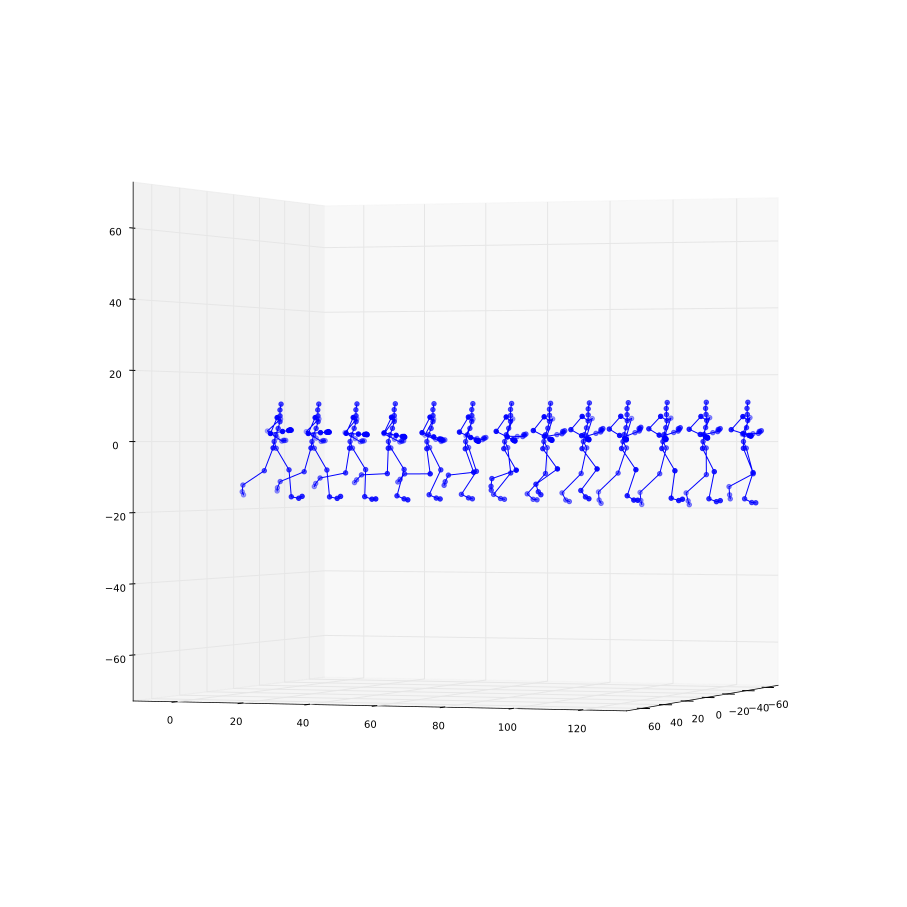

In [16]:

helper.save_trail((pds[1][:,3:]-mean_list[1][3:])/std_list[1][3:], mean_list[1][3:], std_list[1][3:], m1['skel'], "no_control_fully_observed")

In [18]:
def plot_pred(seq, win_out, model, data_in, dim):
    D = np.shape(data_in[0])[-1]; print('Dimensions: ', D)
    m = RGP(wins=[win_out], with_control=False, X_dims=[D], num_inducing=100, kernels=[RBF(win_out*D, ARD=True)], ctx=ctx, dtype=np.float64)
    m.load_params('../models/no_control_fully_observed/'+model)
    #data_in[seq].shape[0]-win_out
    y_pd = m.freerun(data_in[seq].shape[0]-win_out, init_X=data_in[seq][:win_out,:], mean_predict=False, nSamples=100)
    pred_mean, = plot(y_pd[:,:,dim].mean(0),'b', label='prediction-mean')
    pred_var, = plot(y_pd[:,:,dim].mean(0)-y_pd[:,:,dim].std(0)*2, 'b--', label='prediction-variance')
    plot(y_pd[:,:,dim].mean(0)+y_pd[:,:,dim].std(0)*2, 'b--')
    ground_truth, =plot(data_in[seq][:,dim],'r',label='ground-truth')
    ylabel('Normalised Value')
    xlabel('Samples')
    title(model+': Dimension-'+str(dim+1))
    legend(handles=[pred_mean, pred_var, ground_truth], prop={'size':7})
#     savefig('../images/no_control_long_'+model+str(dim))

Dimensions:  6


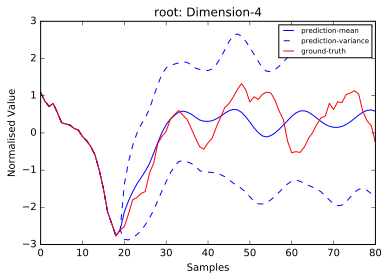

In [21]:
plot_pred(0, 20, 'root', y_test_list[0], 3)

# 2. With control signal

In [5]:
train_motions = ['17', '18', '19', '20']
test_motions = ['21', '22', '23', '24']
subject = '35'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=1, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_dict = {'None':None}
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data(item)
    y_train_dict[y_bones[i]] = out
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_dict = {}
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data(item)
    y_test_dict[y_bones[i]] = out
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    

In [ ]:
for j, bone in enumerate(y_bones):  
    print(str(j)+'-'+bone)
    y_train = y_train_dict[bone]
    if bone is 'root':
        u_train = [np.ones((np.shape(y_train[0])[0],1)),
                   np.ones((np.shape(y_train[1])[0],1)),
                   np.ones((np.shape(y_train[2])[0],1)),
                   np.ones((np.shape(y_train[3])[0],1))]
    else:
        u_train = y_train_dict[u_bones[j]] 
        
    YD = np.shape(y_train[0])[1] # dimension of the data, 62 dimension
    UD = np.shape(u_train[0])[1] # dimension of the control signal
     
    ## Initialise model
    win_out = 20 # only consider the feature from previous time step
    win_in = 20
    m_control = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, num_inducing=100,
                    kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m_control.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([4.]), np.float64))
    m_control.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_in*UD,))*8,np.float64))
    m_control.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))

    ## Train model
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.2)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'null' # fix the noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.1)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=2000, step_rate=0.05)

#     m_control.save_params('../models/control_signal/run/'+str(bone))

0-root
58235437.19719124
39374638.682013
25566303.899066504
16256683.51233837
10256633.311273046
6532068.145339643
4297801.17359329
2981959.7322389623
2201137.5000694133
1721225.0057403431
1408318.9241802045
1188806.2643787768
1023214.7835385844
890856.2739122165
781118.3937816021
688499.8738907352
609846.0050470999
543062.7976037416
486513.34303475934
438707.09442198323
398226.16715909773
363739.9721922735
334107.42738489975
308427.7884863046
285990.1383272403
266210.53823034436
248606.61368993565
232795.73050333682
218488.52270522376
205468.40782815064
193572.23986419366
182682.72207518347
172723.92397619123
163643.66891182272
155385.49760105106
147867.63350765788
140984.02478482045
134630.6253890407
128736.12373106327
123271.09458596846
118232.50616899595
113619.78444641046
109417.84538642524
105591.86199891957
102091.00350243248
98857.10814058346
95834.59980657883
92978.2430466815
90258.36836354042
87664.79735497569
85207.28265798194
82906.76859958575
80777.47821107249
78813.103455

6242.24004545793
6221.02777068351
6199.900906316741
6178.859191621585
6157.902370542546
6137.03019023412
6116.242403525137
6095.538766150668
6074.919037899046
6054.382983712378
6033.930370968462
6013.560971821636
5993.2745592775855
5973.070910750727
5952.9498078536435
5932.911032472071
5912.954370262342
5893.079607972544
5873.28653563769
5853.574945113075
5833.944628607074
5814.395379631098
5794.926993901432
5775.539266657866
5756.231993565268
5737.004970396673
5717.8579927106675
5698.790855511132
5679.803351776882
5660.895275548
5642.066416986174
5623.316564325808
5604.645505767166
5586.053023453904
5567.538898768446
5549.102909693496
5530.7448282433725
5512.464424554964
5494.261463201365
5476.1357039704435
5458.086901516634
5440.1148039809505
5422.219155898003
5404.39969360283
5386.65614816902
5368.988243024625
5351.395695821613
5333.878217146348
5316.435508248638
5299.067265045342
5281.773176881359
5264.552920253553
5247.4061700251905
5247.4061700251905
6367.604123070072
4420.123068

-789.821871116711
-789.3808988739706
-786.2512769878053
-785.237633046768
-789.5798997454053
-793.0068899234707
-792.1427615603985
-791.170269253221
-792.8112121859606
-795.9464535545743
-796.5845635076578
-795.155471892773
-796.1124484103204
-798.9329520723295
-799.1711212681746
-797.947167812079
-798.9060317917168
-803.282551345085
-804.4443993267614
-802.2126216856486
-802.1346505907861
-804.5234629996799
-805.7224984568654
-804.9804026193171
-804.8117792415114
-808.1832341936461
-811.0863678869091
-811.4395600061243
-810.5070763389148
-808.9379659159213
-810.1693627060499
-812.6016729082725
-813.7671123114385
-813.0229875928675
-813.0201872007722
-815.533420014389
-817.7641198678875
-816.9815825575591
-816.0441542437469
-817.5169402505646
-819.9509043259925
-821.481916493988
-822.24157823748
-823.0325024470837
-823.7343471372017
-822.919626815602
-822.5091060921956
-822.3534878225203
-824.6144688281022
-824.7413683810481
-826.8313144580591
-829.2922498772854
-830.0245553455132
-828

-2088.691568399607
-2088.681346315435
-2088.899787253711
-2089.206912073499
-2089.157714760556
-2089.399629408458
-2089.921148101146
-2089.9069238693437
-2090.0402409649782
-2090.4371755966586
-2090.476324811759
-2090.6516357579803
-2090.9268171335107
-2091.0435973140984
-2091.232927447963
-2091.425266719011
-2091.593910366605
-2091.750665977784
-2091.881951259001
-2091.953480221293
-2092.0008701253837
-2092.1881610625674
-2092.2262596879705
-2092.2533538388616
-2092.6367753662503
-2092.885622646213
-2092.9193983742184
-2093.1483279155445
-2093.3861113213297
-2093.5383059505884
-2093.7714104229367
-2093.823562874759
-2093.8056035508444
-2094.0806788255377
-2094.4189858145987
-2094.6266692008307
-2094.730857362071
-2094.8832634993587
-2095.076623593156
-2095.132114662871
-2095.2212232010907
-2095.373043939443
-2095.5064086196508
-2095.7466928794893
-2096.00489103257
-2096.1089112033637
-2096.1922928563586
-2096.4523119417995
-2096.686612876578
-2096.747668223049
-2096.8898459241727
-209

-2135.6804356290604
-2135.6047959988073
-2135.488850597229
-2135.505050394316
-2135.6825754710594
-2135.9016568221978
-2136.0606769696715
-2136.1678802039014
-2136.237313828152
-2136.271036847795
-2136.257351499422
-2136.1512294630325
-2135.960448616701
-2135.92350720417
-2136.2525120033342
-2136.6708656722994
-2136.771840935728
-2136.6597477371224
-2136.692003649884
-2136.955102523195
-2137.1765456889448
-2137.2007067139243
-2137.197454192443
-2137.2721459675568
-2137.3383007189736
-2137.348518684804
-2137.352076028319
-2137.3802775428057
-2137.366727868401
-2137.3317181029665
-2137.394556835111
-2137.587357638702
-2137.7932598773323
-2137.9341016193803
-2137.993335730819
-2137.974889252694
-2137.9335525000133
-2137.9907135057033
-2138.1456449730135
-2138.264913571968
-2138.2973015346215
-2138.3414088614186
-2138.491876571245
-2138.73453831204
-2138.937943004586
-2139.0017477994775
-2138.951835528291
-2138.9188465994025
-2138.9533232787626
-2139.0067388547204
-2138.9692303857682
-2138

-2158.619995670545
-2158.689867132309
-2158.876094406758
-2158.953567689512
-2158.8064393015875
-2158.5999006957386
-2158.648438895885
-2158.8584460852844
-2159.0934421067514
-2159.155860020509
-2159.0602134726473
-2158.9128044341023
-2158.764916274825
-2158.823608075919
-2159.015875183133
-2159.2130914409245
-2159.343443146886
-2159.3864409284424
-2159.4328491664783
-2159.44245072365
-2159.40685073898
-2159.3354490811125
-2159.2962869440216
-2159.391466950702
-2159.5755621703393
-2159.768804063982
-2159.9042474727685
-2159.916585967943
-2159.863397580233
-2159.8025790562406
-2159.786248740634
-2159.806638580015
-2159.758928432805
-2159.656327889793
-2159.5901842354515
-2159.6825333680754
-2159.9083841493966
-2160.029775190955
-2160.0688347204677
-2160.1345356081047
-2160.3067117735072
-2160.44412159266
-2160.4257064079156
-2160.3759744943086
-2160.3824200000727
-2160.403512089397
-2160.285088896153
-2160.153546763533
-2160.2007867606258
-2160.375386585177
-2160.460851053956
-2160.4925

-2173.0776920882918
-2172.7912647328785
-2172.5293947472596
-2172.819585305535
-2172.791136508258
-2173.19902500184
-2173.468755940533
-2173.1220451981344
-2172.9327033634627
-2172.671444378698
-2172.999880616033
-2173.3988998970854
-2173.2289059347304
-2173.0417203789157
-2172.748599970426
-2172.7709019763906
-2173.1826438005446
-2173.3309418335803
-2173.011549966663
-2172.10369113425
-2171.231531832542
-2171.567499557104
-2172.4853369973353
-2172.4188154555086
-2172.0101326622703
-2172.6197317102888
-2172.8546565065785
-2172.3505695824815
-2172.9650796128917
-2173.65707032858
-2173.291155740135
-2173.171384926735
-2173.1045177946817
-2173.562673987799
-2173.9314252965296
-2173.55003951901
-2173.5372798439366
-2173.8343505820267
-2173.9945097638943
-2173.9774849581204
-2173.7322198667503
-2173.775624218365
-2174.136243591988
-2174.436049788127
-2174.1215257049503
-2173.533917467737
-2173.5734044226647
-2173.7786950738673
-2173.45709889693
-2172.8285891706705
-2172.959561735322
-2174.0

-2183.3138825406363
-2183.0307720802366
-2182.7754776755255
-2182.998590583055
-2183.188481629271
-2183.4500800632004
-2183.4992097671616
-2183.433249576639
-2183.348418883308
-2183.3854910105847
-2183.5836945439273
1-lfemur
31728325.75647068
22611138.384048197
15453910.06061656
10251072.64128123
6669895.356627946
4332858.955613776
2868457.6307036467
1972988.488412014
1429981.79536279
1096179.6459647892
882403.6912816443
736598.9888343902
629983.8340032327
547194.7955767511
480112.67392682476
424333.1959808905
377273.81659196026
337224.5334971415
302919.81571867946
273361.9992283192
247747.67019389675
225432.1350210301
205900.66488410078
188738.1296964529
173602.64426537591
160205.9120379616
148299.88395982346
137669.23233621017
128128.06750625576
119519.65466961765
111716.98225453128
104621.04536368794
98155.37303693987
92258.20307413313
86875.19943061587
81955.18296276742
77449.576136594
73314.14579678826
69510.71031824543
66007.4075171645
62777.69587302019
59799.06944546015
57052.04

2487.6259154714908
2477.0335346560196
2466.486983580939
2455.985943196594
2445.530099835809
2435.1191470277754
2424.7527827285394
2414.4307104749196
2404.1526392096853
2393.918283737784
2383.7273632730708
2373.579601877811
2363.4747282780218
2353.4124756678666
2343.3925815043226
2333.414787312307
2323.478837869112
2313.5844822409704
2303.7314723560867
2293.9195634327443
2284.148514381774
2274.418086420947
2264.7280440884506
2255.078153287265
2245.468182907115
2235.8979046527256
2226.3670911232684
2216.8755174414728
2207.4229599422515
2198.0091972115774
2188.634009377218
2179.2971774311513
2169.9984837046527
2160.737712336593
2151.514648054914
2142.3290766668315
2133.180784991862
2124.0695607966395
2114.9951927432307
2105.957469794064
2096.9561828153546
2087.9911223546437
2079.062079715157
2070.168848008645
2061.31121944237
2052.4889880072897
2043.7019483864947
2034.9498949069318
2026.2326236570295
2017.5499309107395
2008.9016136685634
2000.2874696735373
1991.7072969124022
1983.16089518

-1972.3520409071707
-1973.2900065731437
-1974.3429260408652
-1975.006414538897
-1975.7059359010195
-1976.6748758871952
-1977.4069205389624
-1978.1063136504383
-1978.9627004771346
-1979.938474071854
-1980.6516145060223
-1981.4406321951378
-1982.3275578166094
-1983.1541939005317
-1983.8880762010551
-1984.6398844339212
-1985.434255838777
-1986.1863681256968
-1986.915822107807
-1987.6265555194389
-1988.3951441509826
-1989.090340795837
-1989.8007130149476
-1990.4663123092273
-1991.2760976838963
-1992.0328100933307
-1992.8455759098513
-1993.5966960060778
-1994.4145067313682
-1995.204961912409
-1995.9669045152107
-1996.6920128534139
-1997.407984727698
-1998.1349558248044
-1998.8615708742168
-1999.5740233768347
-2000.2614373513868
-2000.9344283925284
-2001.5694739988292
-2002.2026028538717
-2002.72814741033
-2003.3476125207371
-2003.8321027223697
-2004.70929805931
-2005.541971065305
-2006.4682781468719
-2007.2801180304489
-2008.0048585564164
-2008.6604169991776
-2009.2485284179454
-2009.811739

-2403.73261117714
-2404.1815768516894
-2404.8035199810756
-2405.5220277242347
-2406.2597812221975
-2406.8227820659536
-2407.326514776296
-2407.889937108811
-2408.3891087110273
-2408.888996966206
-2409.3779139731696
-2410.0416417615043
-2410.767804242744
-2411.478878404124
-2412.0203423405937
-2412.485656504782
-2412.8651773209217
-2413.131180778778
-2413.591521178986
-2414.132563221296
-2415.0679156351107
-2415.783704819469
-2416.273057566535
-2416.625698142295
-2416.9769419546647
-2417.587961504883
-2418.2935466966446
-2419.031874322241
-2419.561292622531
-2419.945332662866
-2420.221501035379
-2420.618897687078
-2421.2568822728354
-2422.0936437522114
-2422.811673983887
-2423.308486661588
-2423.69361200842
-2424.0933593806562
-2424.473621050829
-2424.868307218134
-2425.417189150493
-2426.0877107853707
-2426.771534109723
-2427.2637415552254
-2427.691817765533
-2428.0299252255127
-2428.543233095325
-2429.12136628766
-2429.7783390805653
-2430.3871754828833
-2430.87913393547
-2431.32646977

-2561.906109441573
-2562.1386526533456
-2562.4874377610336
-2562.80959214826
-2563.173942411452
-2563.2262109326434
-2563.301889943901
-2563.478651999334
-2563.8647315084254
-2564.00395299936
-2564.000344695471
-2563.9674474868584
-2564.511805683095
-2565.2115544928843
-2565.757343576827
-2565.883970450404
-2565.829046852976
-2565.7960029776154
-2565.7611547122788
-2566.0709708991717
-2566.6755869457375
-2567.1014727406973
-2567.0475379166983
-2567.090641061529
-2567.2991487929653
-2567.6884885979407
-2568.2150448681814
-2568.414271973019
-2568.475345982765
-2568.634050589744
-2568.908854008372
-2569.2578081137963
-2569.596522809974
-2569.876878386308
-2570.1683007727534
-2570.3594200846587
-2570.5498516298003
-2570.7364990703413
-2570.8666454671147
-2571.172705850915
-2571.4806045569576
-2571.946567590396
-2572.2922343585874
-2572.3738442432104
-2572.2128755259064
-2571.8265781878654
-2572.3587257254594
-2573.0102157348115
-2573.522102330937
-2573.549156987474
-2573.391576499494
-2573

-2641.8110506461444
-2641.8592690046685
-2641.8229681617377
-2641.774664625139
-2641.925247517511
-2642.2459035831644
-2642.428435335759
-2642.565070873995
-2642.5397029889527
-2642.6313354789295
-2642.5363387147245
-2642.8569127572778
-2643.423842532813
-2643.8031250482245
-2643.708299697423
-2643.282853080645
-2643.0295137993385
-2643.157196612845
-2644.288927487567
-2644.3000772742266
-2643.4579407494866
-2643.3656618174937
-2644.172755646489
-2644.9230328361327
-2644.07050014155
-2643.6362067867462
-2644.8460447826906
-2645.316421193797
-2644.6164885427047
-2644.7720220003557
-2645.645098780744
-2645.9371222359373
-2645.3985660468434
-2645.6448470290743
-2646.354634714101
-2646.449065929085
-2646.2059499915713
-2646.367760017056
-2647.1484290647695
-2647.2994677667457
-2646.8708585564473
-2646.997597011411
-2647.411893447566
-2647.7171244732626
-2647.592252131286
-2647.6283361699525
-2648.0583454036237
-2648.375765716036
-2648.3998277251235
-2648.337526320995
-2648.5040245994333
-2

-2692.132140688759
-2691.9315233582365
-2692.374381581568
-2692.806947295913
-2692.395677904956
-2692.3525532703334
-2692.935539481191
-2693.2602570612744
-2693.023370446816
-2692.8455894122244
-2693.127794049158
-2693.1746730824543
-2693.255762552678
-2693.650073044552
-2693.864589077313
-2693.6699913051584
-2693.082887095579
-2693.4739754841253
-2694.247507364174
-2694.3561459369057
-2693.9795781925714
-2693.479154826522
-2694.085837733182
-2694.6695425831435
-2694.4747995427933
-2694.285636210164
-2694.3196310967696
-2694.8684524401087
-2694.9480467756275
-2694.7799234455547
-2694.9570400085
-2695.069441093558
-2695.4027484743888
-2695.5925871968934
-2695.412216708198
-2695.3718396401573
-2695.4479667426995
-2696.116487655368
-2696.134173975138
-2695.457944883932
-2695.72744059905
-2696.5257424332303
-2696.6886614680157
-2696.073130525463
-2695.543259057681
-2696.716120621358
-2696.905972779586
-2695.7542201158963
-2696.3164272757817
-2697.3436732535215
-2697.2745325125093
-2696.670

-2728.4358100285926
-2728.504566133736
-2728.8945150181667
-2729.3801844474283
-2729.2896766537233
-2728.711563510419
-2728.6718182710865
-2729.016228835959
-2729.488641503219
-2729.566257175469
-2729.419418381379
-2729.2877097525475
-2729.199036828555
-2729.6106335548648
-2729.92545857061
-2729.9516778786783
-2729.764003275443
-2729.357294283584
-2729.891868930068
-2730.3682677164393
-2730.1568642830002
-2729.83196635995
-2729.5080687801383
-2730.4262797140673
-2730.4856682196532
-2729.4730753293643
-2729.8501181539837
-2730.585578145498
-2730.725255590897
-2730.1977274473084
-2729.9425355149788
-2731.01894812108
-2731.0374015491716
-2730.211086078484
-2730.7922810122614
-2731.495025345079
-2731.267565448618
-2731.0735401567963
-2731.2427117013185
-2731.7691479126606
-2731.715789609497
-2731.4071227721124
2-ltibia
5401044.67483312
3047683.24464644
1819582.8399744218
1082539.3236443535
648292.2069919852
399862.97400980274
259053.9119550375
178673.52423354017
131917.2043799981
103815.15

-192.0824384193583
-193.95447207335275
-195.81744476420874
-197.67142341733341
-199.51647409404305
-201.35266215055145
-203.18005235592562
-204.99870880562568
-206.80869480385275
-208.61007324034807
-210.4029061464034
-212.18725515378222
-213.9631811883188
-215.73074469253078
-217.49000531624677
-219.2410224868836
-220.9838548637867
-222.71856068381192
-224.44519767310146
-226.1638230471019
-227.87449342095977
-229.57726525741242
-231.27219422379937
-232.9593357449034
-234.6387446894619
-236.31047559396478
-237.9745825674463
-239.6311191923454
-241.28013885027642
-242.92169430766216
-244.5558381532333
-246.18262236947038
-247.8020987697646
-249.4143186932879
-251.01933320876873
-252.6171930221658
-254.20794838449848
-255.7916492947681
-257.3683453064016
-258.9380858255905
-260.50091972446637
-262.0568957351992
-263.60606215927373
-265.14846706174063
-266.68415799313004
-268.21318236132913
-269.735587257591
-271.25141944092474
-272.76072525766256
-274.263550818001
-275.75994191981795
-2

-1056.8856988498258
-1056.9963879045424
-1057.10223679924
-1057.2217007484555
-1057.3468546396514
-1057.4705516856693
-1057.5882500936787
-1057.7019569940046
-1057.8256333610584
-1057.9353625944082
-1058.0564226857284
-1058.1719797925598
-1058.2838607718204
-1058.39872411512
-1058.5178700769031
-1058.6425580824994
-1058.7645718898614
-1058.8774751862666
-1058.9869249727815
-1059.0927102988876
-1059.211004823425
-1059.3317674208172
-1059.449823149402
-1059.5613150755694
-1059.6664563367074
-1059.7719285690089
-1059.876170551236
-1059.9879402404035
-1060.1046399671857
-1060.2138559962673
-1060.329391197115
-1060.4379557650723
-1060.5500508698815
-1060.6623576533937
-1060.7764423058788
-1060.8875447483679
-1060.9941020023386
-1061.1044247247314
-1061.2138385621174
-1061.3170268178146
-1061.4167283616778
-1061.508536557247
-1061.6185755274987
-1061.7242379021
-1061.8357876573664
-1061.9538193638484
-1062.0643788215502
-1062.1658524746526
-1062.2656254092835
-1062.3709439355146
-1062.476015

-1598.9439338448506
-1599.3339404009612
-1598.9224367767563
-1597.7210710851687
-1597.8600798792065
-1598.1499655728348
-1598.704730835341
-1598.4605584409815
-1599.135398581718
-1600.1116439760399
-1600.6413207545834
-1601.1051864234337
-1601.54447416331
-1601.7138642516186
-1601.9658701688675
-1601.7535562188207
-1601.275208482868
-1601.9231008735774
-1602.4188301642228
-1603.018205422678
-1603.275445497976
-1603.7110400479514
-1604.1955989261805
-1603.5181052588546
-1603.1527364900644
-1603.3810989302656
-1603.755479350078
-1604.83439987573
-1605.1956757825756
-1605.779155360462
-1606.2227416066694
-1606.5690586694723
-1606.7856621728192
-1606.3744626394298
-1605.8843178776176
-1606.873077174946
-1607.0945321318536
-1607.5701115650415
-1607.6526552590067
-1607.7957426998385
-1608.7319635741565
-1609.0537393825948
-1609.002617913377
-1608.8890015870315
-1609.277536169965
-1609.40983447164
-1609.6959767714368
-1610.345463002488
-1610.6491240123892
-1610.6822392181687
-1610.03163608850

-1667.715274495618
-1667.0502844510409
-1665.9614652871494
-1666.658343538808
-1666.9086023648651
-1667.2970883248308
-1667.739888754345
-1668.1839135655073
-1668.4657644695253
-1668.8123234162804
-1669.0717038672224
-1669.0623731587734
-1668.818627203307
-1668.759546632221
-1669.1745320787716
-1669.407576533437
-1669.6647072956675
-1669.9253155550937
-1670.0430757564473
-1669.7050194824783
-1669.687584243071
-1669.4567213526147
-1670.2894452639612
-1670.5042364860274
-1670.265048095605
-1670.3584322279335
-1670.1306465563714
-1670.3182875511648
-1670.7177320321075
-1670.2692512127646
-1670.21009463247
-1670.6177161188498
-1670.702140432486
-1670.9507234155722
-1671.1466851310563
-1671.0359189711548
-1671.339282717913
-1671.2319690185877
-1671.0169080588075
-1671.6856422274395
-1671.9463518593352
-1671.9941820305019
-1672.4469675924283
-1672.648289667094
-1672.7554074883576
-1672.9154641579257
-1672.8919638823538
-1672.6104821845584
-1672.5927309696683
-1672.7618390013884
-1672.9210855

-1700.8497085098836
-1700.852390132865
-1700.7985211860082
-1700.615545697019
-1700.9857689455357
-1701.141304516264
-1700.9550577780353
-1700.0147121453856
-1700.6914757583786
-1700.9075576290404
-1700.8273612910107
-1701.0432889018132
-1701.1553686481618
-1701.2492107631747
-1701.0230706983662
-1700.6709897491394
-1701.669713989529
-1701.5197222048603
-1701.6536084042223
-1702.0552316142096
-1702.095899703566
-1701.9849249252536
-1701.7929419993948
-1701.9557223525762
-1701.893571853136
-1702.1789983308809
-1702.3958964951562
-1702.256598483994
-1702.1465675633756
-1701.781012029013
-1702.4497088773087
-1702.4324757617583
-1702.2227386544944
-1702.6138590069618
-1702.830032338873
-1702.9714542072484
-1702.885468687547
-1702.6014379663554
-1703.0516695268964
-1703.1530804796816
-1703.0472257949896
-1703.3236992858226
-1703.3343569668796
-1703.135095237684
-1703.0650396212661
-1703.455562442301
-1703.6114973132164
-1703.531515585009
-1703.3870393260552
-1703.361852572344
-1703.19378628

-1721.0794942823418
-1720.7460028920882
-1719.7879333541923
-1720.2872802687186
-1720.3096648074825
-1720.607632201557
-1720.68403647622
-1720.868090042329
-1720.9715400833572
-1721.438131632399
-1721.3685959803186
-1721.383573637268
-1721.2787112330152
-1721.2937545543887
-1721.643099032724
-1721.7261940717397
-1721.8547499172705
-1721.7588552781042
-1721.7491060942264
-1721.7149561887777
-1722.2093110585774
-1721.7982886045866
-1721.3961522886357
-1722.0324766784906
-1722.0681075262503
-1722.3112214460507
-1722.303122608903
-1722.3854075956126
-1722.4829500527485
-1722.1794579650925
-1722.1374671430156
-1722.3631845255586
-1722.397403484512
-1722.6990512449024
-1722.5011907158735
-1722.6170200927959
-1722.3238359410473
-1722.6222542068658
-1722.5246435391443
-1722.6623063740878
-1722.6229773520486
-1722.8050378137245
-1723.0104936662656
-1723.1632715194924
-1723.0603699108763
-1722.8903087173599
-1722.6319846181063
-1722.909269132716
-1723.0806335975433
-1723.1892468865863
-1723.4092

-1735.8737447847857
-1735.967741853342
-1736.1448169334158
-1736.1560627622557
-1736.0634007196406
-1735.6692540622673
-1735.8705100324783
-1736.1593323779211
-1735.9438530981931
-1735.2663505565793
-1735.7885620356074
-1736.1888018400673
-1736.0706113918154
-1736.1128456405652
-1736.2207528543065
-1736.3259942356106
-1736.300004547506
-1736.095103266736
-1736.1063982426026
-1735.9493623967028
-1736.275558023181
-1736.2700052963526
-1736.2249478958877
-1736.398987862701
-1736.1663363777436
-1735.9229425746876
-1736.45891026425
-1736.3147948914025
-1736.603254422949
-1736.792069216994
-1736.8460456155258
-1736.751862094618
-1736.8382998852187
-1736.8937592534717
-1736.8562517593446
-1736.8670532618896
-1736.6156202856191
-1735.7153125116674
-1736.349097109549
-1736.2660775269803
-1736.4999784732424
-1736.921742696703
-1736.9010915778972
-1736.8020068049798
-1736.4987818176728
-1736.4723213126783
-1736.7281507600164
-1736.6878421375047
-1736.9493760053767
-1737.1233592765893
-1737.251790

980.756505159171
976.2683807070568
971.8069506304736
967.3718322905715
962.9626519846405
958.5790444177994
954.2206539717203
949.8871335255802
945.5781453519771
941.2933605460688
937.0324595755139
932.7951316491535
928.5810746379748
924.3899958849603
920.2216108433375
916.0756435696957
911.9518267910975
907.8499010843304
903.7696149580487
899.710724273104
895.6729927918955
891.6561907719852
887.660095175262
883.6844893878131
879.7291631213056
875.7939112880613
871.8785345105705
867.9828382565743
864.1066330623546
860.2497340101011
856.4119598967039
852.593133781081
848.793082741652
845.0116366046461
841.2486293034012
837.5038973696827
833.7772803089829
830.0686204139458
826.377762631263
822.7045544283014
819.0488456679905
815.410488262903
811.7893365831495
808.185246836434
804.5980775538279
801.0276887243047
797.4739424900307
793.9367028509919
790.4158353623018
786.9112078265625
783.4226890364106
779.9501499391085
776.4934626739429
773.0525014390353
769.6271417927227
766.2172606324469


-655.5106485364955
-655.4545813156359
-656.079596910242
-655.9016972202405
-657.0938701285154
-658.8356727613242
-658.2901953133429
-657.4188004177114
-658.6643217283739
-659.0399053245984
-658.4306468083771
-658.0370678229772
-656.32965259392
-657.5353057242324
-659.5106215230921
-659.2288671278932
-658.3531972881375
-658.431526474236
-658.4988100086655
-659.4233696220555
-659.9434652895311
-658.98121268665
-660.1789343476927
-660.9523696493998
-660.3515262404537
-660.678189913499
-660.8912041825047
-661.22469493776
-660.2834528793533
-660.3926018122833
-661.0722268837436
-662.7309006641967
-661.649363893944
-660.8980746823972
-662.460199646792
-664.0327741721546
-663.2440790828897
-660.915652772895
-662.7481531336027
-662.8859583741486
-662.046483758691
-663.6536153328049
-662.9161083465701
-661.7464720445851
-662.9033563605022
-663.1087784246448
-662.8115445429668
-663.7938678824944
-663.9892442627258
-664.0215976639174
-664.6651068337346
-665.6503337605086
-664.3745073237276
-664.3

-877.7486691429755
-877.7501323345604
-877.7778766513829
-877.882240524357
-877.9450808264048
-877.9347184502712
-877.9996977344344
-878.0934221950625
-878.1308676847524
-878.1819428314859
-878.2425612233696
-878.285132646986
-878.3149981207655
-878.3305995930773
-878.317918167495
-878.2205646267648
-878.1337154872331
-878.0974688869279
-878.317217686186
-878.5404260309427
-878.571745917883
-878.4535265286522
-878.3191826597213
-878.3908826479753
-878.5993035726059
-878.7890195113881
-878.7743630571944
-878.6519510878458
-878.6038960221903
-878.5823350078911
-878.7217725141511
-878.8644031225524
-878.9388591874157
-878.930536956279
-878.7524561922637
-878.5820719478527
-878.5766560643684
-878.9077043981839
-879.1028816311937
-878.8283844387623
-878.6552363084841
-878.8873644705207
-879.1974177358491
-879.1231260618181
-878.9889562907974
-879.1638027354642
-879.2589997165744
-879.1649961155249
-879.2290418972874
-879.4425649975692
-879.5745068179801
-879.49438335878
-879.3680355324526
-

-888.2645065560166
-888.2178420706489
-888.1708399654376
-888.2470809320371
-888.3623795949948
-888.283184191053
-888.1494526925584
-888.1717875270149
-888.1317590471579
-888.1352912532699
-888.2289434286087
-888.3481416571304
-888.4400021790084
-888.4327972687671
-888.3353051990241
-888.221992976544
-888.2573275903046
-888.4169225606097
-888.4749697305633
-888.4404235085503
-888.4506292462288
-888.442401028027
-888.4125645221807
-888.3571080253271
-888.3341732539692
-888.4744260892631
-888.5841275254468
-888.5519434439806
-888.5124147060965
-888.4588682152496
-888.5703969288115
-888.6754063797323
-888.6224463316294
-888.5501853111781
-888.5590644796766
-888.7467133496523
-888.8785373202193
-888.8101004726777
-888.6450177016875
-888.5332193130604
-888.7130144467864
-888.810314099097
-888.7504903000174
-888.7201429002902
-888.7587440672121
-888.8629725888466
-888.8791459336743
-888.7539978964173
-888.6926241730049
-888.8492447733278
-888.9749013150879
-888.9010009981904
-888.80524982373

-892.8379684187231
-892.8073264087303
-892.7339563060289
-892.6807783307447
-892.7122646847295
-892.7082775842991
-892.6190037935371
-892.6681549820393
-892.62534241307
-892.6203545080243
-892.7905974154277
-892.8922134840109
-892.8618307853808
-892.7945353227353
-892.779197376796
-892.752570502003
-892.6855490513486
-892.711040956535
-892.7593040095169
-892.8199615990652
-892.8190076771016
-892.8199509307179
-892.7812850192843
-892.7345270577589
-892.7760573623335
-892.7669805438361
-892.7627260731679
-892.8876761165876
-892.9124570405065
-892.8476498426388
-892.8506814908994
-892.9306273288694
-892.9960481755389
-892.9426865225993
-892.8225236080343
-892.8525618949975
-892.8918942450503
-892.9991821053161
-892.9913394476956
-892.858591834945
-892.9411338809425
-893.0982814029285
-893.0677033678456
-893.022458507523
-893.020325708495
-893.1212689244093
-893.1835960309679
-893.1542580154334
-893.0500392231048
-892.9900354475702
-892.9593363492498
-892.9575107640636
-893.0808073341674
-

-895.0616828036548
-895.1880898971134
-895.3001626182029
-895.1714259555233
-895.0674906225076
-895.1872318370847
-895.4209686202006
-895.3786506382486
-895.2679720814657
-895.286474158544
-895.187527999948
-895.4127469486461
-895.4018612714078
-895.2354038021075
-895.3836867608379
-895.4081561517696
-895.4004450347376
-895.5163035123608
-895.4071660630357
-895.2851614575584
-895.3033921698417
-895.3621823816062
-895.3319029858358
-895.3450289152281
-895.3687018477034
-895.3292621150758
-895.404022439344
-895.5103907135724
-895.4991219835117
-895.2625242364223
-895.0701736216765
-895.188048032827
-895.3273356932868
-895.4035974317067
-895.4068835878884
-895.3071106131118
-895.2229836800407
-895.3539650801471
-895.4099182348382
-895.3659406066453
-895.4150414027456
-895.3675431336751
-895.372367354232
-895.4818309112476
-895.4732435156174
-895.4759760039086
-895.4607519610362
-895.4006337285638
-895.437119767075
-895.4675815062168
-895.5214464634721
-895.4738951493414
-895.437863022315


-896.9183347083087
-896.9244553279422
-896.9643088143092
-897.0755211750748
-897.0243589781448
-896.9608293279543
-896.8886087615407
-896.8876103235676
-896.9078472669471
-897.0366765923947
-897.0931431300337
-896.972172269475
-896.9575937668133
-896.987022230823
-897.1814105873774
-897.154485082564
-896.9539769212078
-896.9249594300359
-896.9402842398301
-897.1245993264007
-897.12851352948
-896.9531658111116
-896.9855554048224
-897.1030257049863
-897.188078169572
-897.1375325837722
-897.0934922893853
-897.0612178189233
-896.9758441099766
-897.1695782634293
-897.1546750085777
-897.0058045446999
-897.1412136870703
-897.0729233728462
-897.0134737759372
-897.168475170717
-896.99430826389
-896.9197767194402
-897.1023238546719
-897.1376781576839
-897.0492269091137
-897.017218107258
-897.0862220168922
-897.1346295914046
-897.1633962800322
-897.1968738557565
-897.1891258104415
-897.2325456449861
-897.2764161927862
-897.3175992676757
-897.2974500469797
-897.3254256564388
-897.3042989726682
-89

3548.891265127505
3542.2427195921637
3535.5192323248593
3528.7384407893014
3521.9900802239
3515.3279391967735
3508.7313921146124
3502.147503915194
3495.5476813891587
3488.9387734828892
3482.346632658834
3475.790718422493
3469.2717658364886
3462.782991060366
3456.319023221739
3449.874609756972
3443.440791679779
3437.014818703346
3430.6018912587847
3424.2055184384467
3417.827489012647
3411.4720423928775
3405.140326472379
3398.832027143999
3392.5454583634523
3386.278879609932
3380.0314049918156
3373.804110882653
3367.597603541229
3361.413115440795
3355.254875725745
3349.1310975692977
3343.0561342129213
3337.061726353062
3331.200786551178
3325.597771386623
3320.4013140006996
3315.909230565446
3311.815330570125
3307.578733286267
3300.44066094767
3291.51462884118
3283.367846392742
3278.2375343982594
3274.007328687858
3267.5774966122135
3259.811416607537
3253.342814123745
3248.460217423216
3243.224985280569
3236.698586853378
3230.0772697235543
3224.271801465671
3218.9225827822193
3213.3370939

1377.3981454384293
1374.9031739390107
1370.239764852533
1370.607714750613
1366.3460007452456
1369.8061312236232
1371.383035837031
1379.250503763571
1374.977954480842
1370.1650057961251
1370.0900655071937
1370.1683145282016
1372.809808029116
1372.12062882476
1366.4754095301112
1363.8394490693504
1362.734239673493
1360.4372854624467
1359.8413708064274
1362.4895556618708
1364.2165791325588
1368.4519662155683
1361.0825909317061
1358.5087742068374
1358.030198132957
1356.4545086726628
1357.3595718434897
1354.57312812236
1352.0684065489168
1352.033726041957
1352.1227243701214
1355.9592389401218
1360.573271085153
1358.999359791861
1356.06827940763
1353.565571356362
1352.5792154317999
1357.7039599714728
1352.2973528612567
1352.6180513477718
1349.2233635277903
1350.5720615680889
1347.5763639611673
1344.3903551627868
1348.0815642868895
1350.1920255628984
1348.4344787063324
1347.0302377863145
1346.4764545803785
1342.4427444975106
1344.6117794750476
1340.3951832557912
1341.3471213538305
1344.830371

267.9262809630556
267.89935295950613
267.8724753459319
267.8456475022362
267.81886882714065
267.792138738802
267.76545666835113
267.73882206540986
267.71223439284483
267.6856931283351
267.6591977612152
267.6327477989794
267.6063427552512
267.57998216029443
267.5536655515652
267.52739248001774
267.5011625068898
267.47497519964884
267.44883013775984
267.4227269093311
267.39666510952947
267.3706443423136
267.344664219098
267.31872435949094
267.292824388223
267.26696393942046
267.2411426496131
267.21536016650816
267.1896161395678
267.1639102245363
267.1382420830986
267.1126113844855
267.08701779938343
267.0614610040549
267.0359406814679
267.01045651777173
266.9850082039242
266.95959543585184
266.934217911513
266.90887533374837
266.88356741183804
266.85829385501194
266.83305438053753
266.80784870447377
266.7826765504949
266.7575376439361
266.7324317143013
266.70735849467377
266.6823177222805
266.65730913575356
266.63233247710474
266.60738749251925
266.58247393140107
266.55759154490977
266.5

258.59113766040525
258.5753051126177
258.55949447248634
258.54370474494823
258.5279334075545
258.5121788154269
258.49644146934213
258.4807228522701
258.4650242120778
258.4493454086512
258.43368587883015
258.41804597947265
258.4024275814899
258.38683501332207
258.37127643409434
258.3557682756723
258.34034400769076
258.32507791783024
258.31012647019253
258.29584680739333
258.2829714360581
258.27319018421275
258.26936440897975
258.2770269607922
258.29578227537536
258.316204852482
258.28772377716496
258.2182872050514
258.16307616832967
258.1665906892237
258.18797239923407
258.1687645410267
258.12148074674303
258.0882196250678
258.0862261598604
258.0874828782773
258.0652807374878
258.03344707134016
258.0133061008468
258.0056221045978
257.995189348604
257.97467372581593
257.9536715716692
257.93778866739547
257.9245924832691
257.90858003082315
257.89045029339957
257.87532746612266
257.8616464016713
257.84579595186847
257.8271227756351
257.81043900837705
257.79765615862885
257.7849618133612
25

253.04357129735723
253.05549986983365
253.05007734295395
253.0306037933345
253.01395037250444
253.01713958671866
253.03368184946234
253.04744191126127
253.01751217432866
252.96581462307554
252.93499721815635
252.94053215447718
252.94455195350625
252.9247657153991
252.89354949877077
252.86719728125257
252.8603400312046
252.8695065523526
252.86984409180624
252.85031134497754
252.82132157415234
252.80095767924809
252.79600745283182
252.80156025702257
252.8103463412321
252.8123450579688
252.82055264681009
252.8287389552262
252.84673289669894
252.80803809188802
252.75561716077175
252.74487648543874
252.76097979745128
252.74312416674215
252.70663731776534
252.69067005581826
252.6926264597365
252.69017729969403
252.6712526882513
252.65294093414346
252.64242330510913
252.63149680181738
252.61553372052606
252.60328670285813
252.59285490278546
252.58513586866832
252.57671551424124
252.57042389720058
252.56612683124047
252.56676143082672
252.57212361455873
252.55876034872506
252.52763216123955
25

249.35375441250417
249.34939248075491
249.34522560290452
249.32997037550686
249.33283308045412
249.36388859305896
249.38613314575204
249.3886188532805
249.34092822846034
249.30021510686385
249.30108651752764
249.32596549505996
249.32046027244445
249.26748935219882
249.2420071904703
249.24836319641943
249.24620247025774
249.2317524467377
249.21945857499173
249.21219313947572
249.1993841148128
249.19299052043058
249.19312020312339
249.184913620931
249.17740448349548
249.16699299973257
249.17155602962413
249.17550365009123
249.17774835538603
249.17381067522606
249.17703173696344
249.18779046040567
249.19348352565135
249.16741874910178
249.14140795766193
249.1597547161406
249.164855334858
249.14364608605274
249.10573377544563
249.07705960247438
249.10221001758
249.13885391980688
249.13263077852883
249.0617543942991
249.0436064778027
249.07393635357747
249.05543452022144
249.01876908153113
249.0305878090063
249.04906956794494
249.02790455632038
249.00099653784264
248.99006149619015
248.9969

59334.94023724923
56806.49913026697
54454.36723768196
52258.193846907496
50203.450341032134
48280.285561680495
46481.77759139095
44802.15650435896
43235.34694083674
41774.03774755425
40409.44898744828
39131.839950654256
37931.54184132514
36800.06892304007
35730.846378839415
34719.27230062274
33762.1340524517
32856.73338711697
32000.224298382673
31189.468686831315
30421.295584159066
29692.795649307278
29001.40645008567
28344.82923039318
27720.94761268013
27127.817492046433
26563.649788906834
26026.70597905928
25515.15272233303
25027.013346508986
24560.295095482837
24113.213494732798
23684.339757933565
23272.567286161597
22876.951138955785
22496.5610204413
22130.44334255434
21777.681268078264
21437.47879894317
21109.207080529068
20792.393858119398
20486.663104656112
20191.64242074376
19906.870469407597
19631.752287871546
19365.597481732293
19107.728931327983
18857.59900156365
18614.84298032624
18379.241719339865
18150.62492541774
17928.77771630988
17713.40034646181
17504.130797562397
173

2272.994428056114
2264.3851238646084
2255.806716766465
2247.2589037055827
2238.7413794738095
2230.2538363698004
2221.795963373937
2213.3674484116636
2204.967978073621
2196.597234923599
2188.25490329405
2188.25490329405
2879.446202528062
1758.7256452345866
1493.2154772705717
1275.154830709286
924.2850506463576
576.790819840144
317.83660052787513
144.66746572920286
17.687732951808186
-93.60107240298132
-199.3884914124445
-297.23253234389585
-381.9118212976804
-450.830823048522
-504.8474991821507
-546.7134692258949
-579.7406573011145
-607.0257667554429
-630.8268099033603
-652.4661834278764
-672.7428504121074
-692.2634491619172
-711.4573296443035
-730.6094514367719
-750.0193563559767
-770.0309932938387
-790.8922990894758
-812.6719936279277
-835.3887488055457
-858.9855244574533
-883.2751559993519
-908.194589567396
-933.5930840886418
-959.1813367368482
-984.5243641116087
-1009.2406660738985
-1033.1055916755208
-1056.090364821632
-1078.2453257571885
-1099.6210198770302
-1120.136172831266
-113

-1882.5979108399101
-1883.6539987879232
-1884.1353983694034
-1884.5592089977533
-1885.1223399836686
-1885.7861659579637
-1886.2070744004902
-1886.4957401830159
-1887.0005984289307
-1887.6352459938337
-1888.3039639700055
-1888.6957759443658
-1889.066026380241
-1889.5779328744284
-1890.1865832256317
-1890.7290258165872
-1891.2657870725714
-1891.8851515421156
-1892.4733815136226
-1892.7823789478787
-1892.8517003209872
-1892.931432751148
-1893.7004236382409
-1894.4870977151163
-1895.0876461015957
-1895.5373268082724
-1895.9245569160532
-1896.4923400545683
-1897.1010007926823
-1897.9466484388522
-1898.5211084122934
-1898.6498579017893
-1898.8751379072396
-1899.3610733261412
-1900.5960117973482
-1901.321764958355
-1901.3479917140185
-1901.358437606531
-1901.6459299458177
-1903.0042539838646
-1903.8013275795452
-1903.8895203678615
-1903.9413279646128
-1904.0691040869524
-1904.774906814764
-1905.2729433261702
-1905.917474384082
-1906.659106555093
-1907.0970515886206
-1907.392766269302
-1907.72

-2200.5418187956466
-2201.4543854564467
-2201.9083934784376
-2201.87874108468
-2201.7409604702234
-2202.207608898886
-2203.348134052565
-2204.199896760243
-2204.3428563441576
-2204.2574962311346
-2204.4822693233355
-2205.061571490306
-2205.74345511965
-2206.148235484493
-2206.2789707592733
-2206.67008063691
-2207.3025024848557
-2208.04407233184
-2208.4509195615547
-2208.3586774289906
-2208.3830327182554
-2208.7615121307017
-2209.92216290956
-2210.484842659988
-2210.1868643308885
-2210.0864251067455
-2210.832980425838
-2212.131728150837
-2212.4298090178563
-2212.2970226620832
-2213.074544861891
-2214.085814033126
-2214.3814892671976
-2214.132061127026
-2214.1002571028885
-2215.038904081789
-2215.788064444121
-2215.7399807160054
-2215.815756868337
-2216.3815531178816
-2217.42867809614
-2218.006738325903
-2218.1144090869966
-2218.4360061994685
-2218.873515155613
-2219.384495534917
-2219.5538302206487
-2219.3653921881732
-2219.5713671349968
-2220.0414085804287
-2221.140566148829
-2222.0662

-2331.227325020077
-2332.094596560364
-2331.8050247776237
-2331.393987408279
-2332.1685269063328
-2332.8198532237766
-2332.174117215627
-2331.7927915784767
-2332.8346330570757
-2333.784998698738
-2333.8322361184246
-2333.8880371123787
-2334.626486033537
-2335.001673173746
-2334.649596902704
-2334.3737624493965
-2334.498551713664
-2335.107676226764
-2335.3991415891323
-2335.88600172229
-2336.4479467208207
-2336.6628727481407
-2336.4152760724382
-2335.8725570397164
-2336.6745763220983
-2337.8280255083173
-2338.0177724242585
-2337.5368244903793
-2336.972877156468
-2337.862712224273
-2338.7877852033653
-2338.8407386955514
-2338.5613335809608
-2338.0306218311707
-2338.6787247811053
-2339.662492874497
-2339.8489195437337
-2339.3214803465808
-2338.9642185155053
-2340.6600850624054
-2341.164315423922
-2339.91780451581
-2340.395525267929
-2341.8322476467133
-2342.1774052843575
-2341.4822192634874
-2341.214287692529
-2342.6704496978523
-2343.157686642485
-2342.731876155502
-2342.8433914839134
-2

-2410.4281359306206
-2411.5453460554613
-2411.4987083282595
-2410.8659055821427
-2411.381835817483
-2412.209260184534
-2411.868177748035
-2411.4672834310213
-2411.915098126874
-2412.234961664486
-2411.381421782203
-2410.4142110228713
-2411.430925170018
-2413.238024573994
-2412.3066300076034
-2410.9587791343333
-2411.446599274676
-2412.9566381744844
-2413.3751781960173
-2412.314234115911
-2412.051938109408
-2413.567998031394
-2414.1615138912002
-2413.2925320712093
-2413.609195866332
-2414.7221671593447
-2415.032561156304
-2414.615101710084
-2414.5986769091824
-2415.3635503548285
-2415.567842981286
-2415.4272320911546
-2415.7615040360706
-2416.110171178482
-2416.358577884541
-2416.2278914295475
-2415.9441639359698
-2416.4382839894843
-2417.0696527546997
-2417.1028516163615
-2417.057789660508
-2417.2752303751067
-2417.834522998379
-2417.5596983276237
-2416.1881320448206
-2416.400526651907
-2417.6375301984094
-2417.955209305991
-2417.667936158372
-2417.2352268068353
-2417.048478437394
-241

-2465.361534509704
-2465.017305130256
-2464.8743184743817
-2465.332186706413
-2465.737425949158
-2465.3701136174213
-2465.2028940476694
-2465.5483903415566
-2465.932706805731
-2465.968641486781
-2465.4446024213335
-2465.7424242906727
-2466.412848706471
-2466.9231002620886
-2466.6301103861706
-2465.633761334697
-2465.8833831640495
-2467.7113458814265
-2467.5730199900936
-2466.4394602876373
-2466.8508030992484
-2467.401764960068
-2467.3848595670142
-2467.6778526819057
-2467.5953810777455
-2467.3262765960426
-2467.4543855528905
-2467.9854582304274
-2467.310452814699
-2467.3927474847696
-2468.8048618886896
-2468.0322542973654
-2467.074459072614
-2468.449005487719
-2468.5428998970365
-2468.2153315014675
-2469.1257623930073
-2468.787198141099
-2468.6064318889994
-2469.711051467512
-2469.529144168433
-2469.372735992074
-2469.9869471106717
-2470.417592076704
-2470.456939856384
-2469.9220451093265
-2469.824516991457
-2470.655099247785
-2470.9126159572206
-2469.785383931827
-2469.687995005155
-2

182610.60622847086
134777.99939949077
107126.00654629726
90297.85298276992
79175.60122157895
70998.1967565726
64320.76779795313
58431.41962224902
53020.01169053461
47985.76319480556
43324.37193140596
39064.557636582926
35234.017958548626
31839.42033974694
28856.95103085148
26238.90315341347
23928.99269660847
21875.63989896427
20040.265061774153
18400.206559157286
16945.362761953875
15671.122258718357
14575.695051007691
13655.53240625239
12885.700909673833
12209.269805359148
11566.339401642239
10927.438769163802
10296.679173807732
9696.448904596069
9148.673169021156
8661.4771390796
8228.75068839228
7839.169066742026
7483.447712638634
7155.597355675205
6851.019404165579
6564.78074407992
6291.944249694266
6029.6174881058805
5778.196693691091
5540.221113752239
5318.032924300816
5112.314352685081
4922.501117238964
4748.155896867877
4589.213836066306
4444.587644246918
4311.150384235184
4184.806645515533
4062.863172540645
3945.5215522784483
3835.1016660616265
3733.893354550093
3642.7123903881

-104.0684565390245
-105.98010414952238
-107.88406962187773
-109.78039751632892
-111.6691320093193
-113.55031678441675
-115.42399527883589
-117.29021046262325
-119.14900519424772
-121.00042188517182
-122.84450251483223
-124.68128898061033
-126.51082276777092
-128.3331451846218
-130.14829714870638
-131.95631931222903
-133.7572521735452
-135.55113598487802
-137.33801064272325
-139.1179159206197
-140.89089136438395
-142.6569762976677
-144.41620983162113
-146.16863086717785
-147.91427820881125
-149.65319024702984
-151.38540539077218
-153.11096185291944
-154.82989744854694
-156.5422501143737
-158.2480573922682
-159.9473566348998
-161.64018521337286
-163.32658010392853
-165.0065781947054
-166.68021617803615
-168.34753055500568
-170.00855772233055
-171.66333367878582
-173.3118944103519
-174.95427559821584
-176.59051280016695
-178.22064125934094
-179.84469599148494
-181.46271197215975
-183.07472374894553
-184.68076552891438
-186.28087175081527
-187.8750760252932
-187.8750760252932
-72.204146977

-1065.361826530791
-1065.4829660730686
-1065.611360376795
-1065.7410314695676
-1065.8679464329139
-1065.9900944125488
-1066.1105590743648
-1066.2308250955023
-1066.350793662859
-1066.46885278785
-1066.5795193244176
-1066.689246091662
-1066.788868079043
-1066.922225484805
-1067.0527413992984
-1067.1868403778435
-1067.310766111777
-1067.4275575343804
-1067.5408562439761
-1067.6484356056153
-1067.7700080368595
-1067.8914621287086
-1068.018473483206
-1068.1384055216774
-1068.2564081743387
-1068.3684820564245
-1068.4802891941172
-1068.593808391771
-1068.7053687929601
-1068.818436167062
-1068.9224850456221
-1069.0448561519447
-1069.1598155319712
-1069.2806406510704
-1069.3913793038414
-1069.5081965317902
-1069.6238478980167
-1069.7346728535945
-1069.8461778678184
-1069.9502283001166
-1070.0687873584877
-1070.1821867679007
-1070.3033003713094
-1070.4168092916343
-1070.525488944084
-1070.6326687945088
-1070.7338842344325
-1070.8398440594262
-1070.9366709524768
-1071.0616210877356
-1071.1832253

-1641.376509575745
-1641.5515901237084
-1641.7269328707239
-1642.3537995266706
-1642.668761593706
-1642.8788758840412
-1643.5510942726803
-1643.8862340178732
-1644.0168426052373
-1644.0066616191066
-1643.8015322130486
-1644.5147237798208
-1645.1821651514124
-1645.1251131058816
-1644.8385558350517
-1644.557058176721
-1645.4842058837232
-1645.5119916580384
-1645.8530961430793
-1646.3297696990894
-1646.6841929036038
-1646.6063168722198
-1647.2909247962402
-1647.5923410480286
-1647.5378447215246
-1648.0240399280449
-1648.2082123127086
-1648.4397237193298
-1648.9845593098964
-1649.2733397183254
-1649.3780915471411
-1649.5159573344388
-1649.5755381786137
-1649.345323010331
-1648.938618620809
-1649.2701161283335
-1649.9715006908216
-1649.7813984222832
-1649.8451761630943
-1650.4183482297144
-1650.8700652121788
-1651.3896464039617
-1651.5718474709179
-1651.898844858166
-1652.5285116145437
-1652.7453530830824
-1653.2038471474098
-1653.4507122504106
-1653.7121255305467
-1654.05887770248
-1654.40

-1706.1560450420043
-1705.145598981225
-1706.278204442351
-1706.280246639844
-1707.2145419022245
-1707.0631288658717
-1706.4579021521567
-1706.0591348031662
-1706.5898864015558
-1706.6749212818042
-1707.2794663587736
-1707.840858640325
-1708.055730750582
-1707.9807367870312
-1708.1018435918602
-1708.643267059711
-1708.6747182735478
-1708.3672296591112
-1708.6568752096864
-1709.1334607619967
-1709.4230484734069
-1709.4343335549797
-1709.3696974123827
-1709.4081022929072
-1709.5646366349122
-1709.799226418326
-1709.9426961035515
-1709.825953144763
-1709.2454202627782
-1709.3265421784927
-1709.5728928246326
-1709.9426090538445
-1710.1020612807024
-1709.2618184571736
-1710.257273185224
-1710.0186350382487
-1709.1479247468967
-1710.7876793975572
-1710.1733028661706
-1710.0223889928598
-1710.97032900282
-1710.531038494666
-1710.3479129005696
-1711.28027321129
-1710.8489892183027
-1711.5264103901554
-1711.8534761624614
-1711.0613921569889
-1710.3414928862665
-1711.3812511774306
-1711.28676555

-1742.2510830796891
-1742.563524092824
-1743.1494386538775
-1742.4338338896569
-1741.018300222678
-1741.9766428237183
-1742.2292971467684
-1742.8283022090218
-1742.5706208472873
-1742.639144660614
-1742.452786938104
-1742.584222705917
-1743.4157407513449
-1743.075794898727
-1742.5912726319693
-1742.6856188131726
-1742.9201366205766
-1743.3832504864213
-1743.3712612183485
-1742.5827767101296
-1742.841274884661
-1742.662278020793
-1742.9893602759512
-1743.6745540672546
-1743.6941955045652
-1743.7893399713005
-1744.114808707208
-1744.4607553490805
-1744.2091155915002
-1744.1708116313653
-1744.2830424270846
-1744.3039895215422
-1744.2702039392511
-1744.424478595109
-1744.8522019430839
-1745.0283948013407
-1744.9568888846452
-1745.2818604218874
-1744.7870276846497
-1744.3876721250317
-1744.397046537847
-1744.1280587180431
-1744.557037753101
-1743.3150326735795
-1744.3655314326077
-1744.9172335597286
-1744.4213784243786
-1745.351738713296
-1745.0908934769336
-1745.2340030470102
-1745.5447065

-1766.0254312687457
-1765.6566586770655
-1765.687657749616
-1766.0261801481452
-1766.1534882801757
-1765.913149349743
-1765.8370656301902
-1766.4149625668244
-1766.3881192041517
-1765.873527383819
-1765.145241798722
-1765.9651834104502
-1766.0071454356978
-1765.672424334075
-1766.614850584789
-1766.9111409141442
-1766.2571041394108
-1765.7542074614978
-1766.0109435677252
-1766.4063785154372
-1766.789572643781
-1766.5523762281741
-1766.5986609716135
-1766.749962215526
-1766.5771061855612
-1766.681146933749
-1767.079629451578
-1767.059651208312
-1767.1984736731251
-1767.2746882720544
-1767.5087705617384
-1767.856763316699
-1767.8270460242002
-1767.5773903043523
-1767.1622842246088
-1767.2527547553639
-1767.7136740508108
-1767.8810832189595
-1767.5456288191517
-1767.673515764319
-1767.746246186642
-1767.928016429239
-1767.6539911543337
-1766.9803971903284
-1766.9409062785735
-1767.9509228447423
-1767.8214977313162
-1767.7617348989313
-1768.4369770499013
-1768.328055014985
-1768.1374679576

-1784.258117935662
-1784.0678876882664
-1783.9559087134062
-1784.8573469793882
-1784.459957827039
-1784.0211224155355
-1783.2746973742621
-1784.2300757316566
-1783.8435419820144
-1784.8349999327556
-1784.8354037882143
-1785.0532427928865
-1785.2408688286714
-1784.912134549284
-1785.314765596296
-1785.4726427529756
-1785.3388490383186
-1785.2348537517437
-1785.3467640902074
-1785.899501083885
-1785.4342486890203
-1784.9705291270031
-1785.4252941556806
-1785.7268261687539
-1785.32632368084
-1785.7868780888693
-1786.1559426686758
-1786.2897273771505
-1786.1502712652239
-1786.0523873181494
-1786.2527489821193
-1786.2177057010595
-1785.8452369606052
-1786.3776157837938
-1786.4510887918898
-1786.650402957743
-1786.2234261375315
-1784.286068064797
-1785.3676746893689
-1785.131166391333
-1785.5937185942857
-1785.9544275436979
-1786.1963856600173
-1786.3759721821366
-1786.6950440488808
-1786.9965319425237
-1787.2863867279832
-1787.166923630669
-1785.535911119935
-1782.9455488430744
-1783.162540

1063.9198238001848
1059.9892847128099
1056.0778483473146
1052.1853437401558
1048.311602054128
1044.4564565687328
1040.6197426565363
1036.8012977545643
1033.0009613423867
1029.2185746741443
1025.4539810024125
1021.7070258063333
1017.9775562753592
1014.2654215288774
1010.5704725998995
1006.8925624011116
1003.2315454892193
999.5872784831965
995.9596198493751
992.3484295961716
988.7535695279344
985.1749034248992
981.6122963587808
978.0656155692357
974.5347295229909
971.0195086054998
967.5198246235917
964.0355514610372
960.5665639486609
957.1127389542442
953.6739546904012
950.2500909265456
946.841028961334
943.4466518256772
940.0668433877113
936.7014896496768
933.3504776202905
930.0136959719337
926.6910345667746
923.3823846839249
920.0876391720337
916.806691830348
913.5394382291751
910.2857748298944
907.0455998184018
903.818812257644
900.6053126972344
897.4050027238536
894.217785167983
891.0435642778541
887.8822453054554
884.7337348868073
881.5979404268603
878.47477088151
875.3641359500825


-600.0436831946602
-600.9105100605816
-601.5483262182973
-601.2599685082711
-601.2644383645319
-601.7862633487978
-602.0004248740402
-602.6356153626643
-601.9190784468311
-602.5568344927603
-603.5182746323525
-603.7180114114001
-603.4799464404185
-602.4971545198994
-603.4066957717716
-605.2589525536068
-603.5137725437592
-602.1751089242691
-604.0193012142713
-604.6080090921769
-604.0092415294628
-604.9335848108494
-605.969105353807
-605.9917759036234
-605.6218736205635
-605.5224719001743
-606.0783476163937
-604.9925385236596
-606.550234431758
-606.8367356063475
-605.6400551468719
-606.842268327099
-607.0834982610788
-607.2706399940007
-607.3628669512632
-606.902307559383
-607.4494719019658
-606.4357894246691
-607.922467040779
-608.103742751405
-607.2951537322783
-608.8608734775027
-609.0158429147082
-609.6196518155383
-609.7337110096207
-608.591908279034
-609.7369347634535
-610.0826191335918
-609.4459554360001
-610.0450759959305
-609.5142721384152
-610.4698560878071
-610.4304505814571


-833.735885863347
-833.8530711430628
-833.9382643742088
-833.9529484299503
-833.9292289660126
-833.9070634025343
-833.9365505863228
-834.0169232342032
-834.1197733078417
-834.1762227311566
-834.1771520494528
-834.1545819878277
-834.136004141395
-834.1668866746638
-834.2456753528716
-834.3453253837857
-834.4003705769829
-834.4016406522647
-834.3745212673199
-834.3382997059426
-834.348658606508
-834.4098051192847
-834.5222139969353
-834.5762866909063
-834.5496681243737
-834.5105729129922
-834.5357497442615
-834.6601928002042
-834.7676776722303
-834.7828978778653
-834.7438563392756
-834.7137942064242
-834.7494212146881
-834.8324613818104
-834.9042509341341
-834.9071726214778
-834.8762221660772
-834.9058945323133
-834.9962191954901
-835.0947189635274
-835.1228730870275
-835.0923540716666
-835.0678418978111
-835.0798540399028
-835.1599692459124
-835.2488093202868
-835.2844659914415
-835.2700381285581
-835.2559204658462
-835.2922107401672
-835.3629282897882
-835.4420124260458
-835.4837473397

-842.3942584149792
-842.3832362331624
-842.4101567405455
-842.5358800013512
-842.5630994119739
-842.4669815942527
-842.4547234222736
-842.4683150150754
-842.5916597274381
-842.6330834355889
-842.5440262488129
-842.5143727727318
-842.5021273832276
-842.6388924888695
-842.702173145459
-842.6258551288354
-842.572506637184
-842.5189326054449
-842.6619541447872
-842.7587225149697
-842.7090614562898
-842.6322316280222
-842.5278396207718
-842.6679099631309
-842.8000947542225
-842.7714913957
-842.67243339846
-842.5278567755178
-842.6876753373461
-842.8387093834142
-842.7818202269324
-842.6688044240968
-842.5412168781279
-842.7640107106342
-842.8619441981077
-842.6998303263138
-842.6909376361118
-842.7594161583322
-842.9185513921378
-842.88267164532
-842.7024275891249
-842.7630438887134
-842.8791477175645
-842.9547308366457
-842.8899753208409
-842.7490792575663
-842.8603373336305
-842.9950090659977
-843.0137185582371
-842.9467673929864
-842.8245403026399
-842.9125005261968
-843.0082115319558
-8

-845.6200903096885
-845.3790233109161
-845.5923198467087
-845.8042337831225
-845.6995088155755
-845.5297823840231
-845.3536307319514
-845.6699129469929
-845.7291377408213
-845.4765638481348
-845.510219202928
-845.6917246182558
-845.7851852041008
-845.6411429819086
-845.4981343631537
-845.6931391642872
-845.7918615245218
-845.7778090787698
-845.7156297870647
-845.6324187715239
-845.8111654844947
-845.8975917361264
-845.82123077462
-845.7784848828612
-845.7480976036186
-845.9100314057738
-845.9724220110759
-845.8817045098027
-845.7683408583655
-845.6586261145804
-845.9234253828251
-846.0006938554733
-845.7930533569754
-845.6883375079253
-845.6540170474018
-845.9829183110126
-845.8173964016381
-845.46372229316
-845.8038982892823
-845.9888527425805
-845.7909923253142
-845.787319299898
-845.8581484604847
-846.0141679164899
-845.9230124396597
-845.72577704633
-845.8751622676216
-846.0259715814682
-846.0444279028183
-845.930402913424
-845.7892020629477
-845.9799279412338
-846.0947980479375
-8

-847.4046629544478
-847.5913230412118
-847.7444927966184
-847.6655553913374
-847.5651473364159
-847.4242455612318
-847.6713174812053
-847.7319966969433
-847.5579069386223
-847.5427355735565
-847.5309231012275
-847.7035177072997
-847.6707496500352
-847.5132726648201
-847.5725434010644
-847.6253062231849
-847.6969542146103
-847.6806846538543
-847.5512139152222
-847.5822878746196
-847.6351002962614
-847.763066044202
-847.8037033178157
-847.6159866374321
-847.5243044223613
-847.630409921173
-847.8678185693338
-847.7990232978296
-847.5533975720043
-847.5907212555805
-847.6460409101194
-847.8033969324908
-847.7600980492105
-847.5475511670356
-847.6403531403578
-847.7683033075765
-847.8829291721205
-847.7508092525808
-847.5024019284224
-847.7385154972974
-847.9127187174188
-847.8642362688098
-847.688792863038
-847.4719617392944
-847.7635457155968
-847.7831734682959
-847.4133924985774
-847.5287301601346
-847.8086735987345
-847.900246733494
-847.6508579218829
-847.4041073873118
-847.72167044427

-849.2801361770928
-849.3787197959716
-849.4273100832637
8-rtoes
4090995.532269285
2278188.183553021
1377592.8373762902
848084.8862622923
535847.5947669311
352470.0612505452
243573.21581873085
177431.69642317994
135988.65462402994
108991.23640377102
90581.3005744551
77419.672317563
67598.50838078713
60004.110529055375
53954.994833999044
49011.69121977654
44882.66163690822
41372.37095142729
38346.52969753076
35708.41267638388
33385.100897642
31320.904157938592
29473.809173294725
27812.348804375324
26312.482930177546
24954.989512547705
23723.748430503154
22604.8805529841
21586.41277703455
20658.13632210175
19811.419764437167
19038.80952212468
18333.42716290888
17688.432620938376
17096.843586386225
16551.707982139626
16046.452977046985
15575.291267161798
15133.602609482597
14718.164489431907
14327.066717691387
13959.254386680144
13613.873401210803
13289.728967601106
12985.091229273636
12697.871401079787
12426.003089927548
12167.816167583052
11922.2575898359
11688.895017697107
11467.696352

2574.8041272146256
2569.8290943672096
2564.8677191856627
2559.9199305362135
2554.985657942139
2550.0648315670815
2545.1573819310715
2540.263240485691
2535.382339012138
2530.51460991917
2525.659986535887
2520.818402499799
2515.989792353516
2511.1740906363016
2506.3712327916396
2501.5811551386364
2496.8037939899673
2492.0390865210074
2487.2869701968575
2482.547383335437
2477.8202648160795
2473.105553822504
2468.403190162922
2463.713114861578
2459.0352702689356
2454.3696036592737
2449.71607774709
2445.0747121005547
2440.445733282536
2435.830153489785
2431.23197744154
2426.666833372426
2422.19557588162
2418.0549360423115
2415.1070455123217
2415.7822949480583
2420.522977834073
2413.19075541302
2397.002830165444
2398.7804001165114
2392.5142270472247
2383.3310353183024
2384.495602276712
2374.5713100489115
2372.04947873082
2367.7126156097515
2360.607825993393
2359.1391689225848
2351.2641404979713
2349.0298192096575
2343.1914788843137
2338.885035809263
2335.1016037872228
2329.211171142655
2329.

830.6473401354673
830.8970024707158
831.1675253200337
830.650867863134
829.9176597158306
828.5868569413392
828.6739287911187
828.399580512563
826.8378975198324
826.7159203562824
828.2240641425285
827.9624692631878
825.7332855163156
824.8748931878686
825.5351778927368
825.9737704252253
826.0023981313816
826.499205214895
826.8572965123643
826.8766972853156
825.9020205973103
824.9176995960887
825.9640144039035
825.8559908957152
824.050530857918
823.8903469455558
825.6012889482607
826.3101818715312
823.6379181752131
823.3721578163961
824.4210802711709
823.2404137129286
821.8748762577311
822.1358750144074
822.7842313561814
822.9151565913608
822.2519915046867
822.2864893257954
822.9675813373992
821.545246539584
820.5907876377469
820.6629840811504
821.7125300317816
823.2131812091395
823.7726176629169
823.6296723741625
822.117690017408
821.587461648497
822.3420971731799
821.8489311106924
820.060601273553
819.6086113373324
820.1748796585472
819.8017659844263
818.7558722451358
818.5607861835045


119.00019167866262
118.98243443425687
118.96488074124711
118.94752403702239
118.9303577615351
118.91337539019895
118.89657046297341
118.87993661624714
118.86346760364684
118.84715732188639
118.83099983049895
118.81498937062642
118.79912037579416
118.78338748790952
118.7677855625546
118.7523096777213
118.73695513639132
118.72171746539269
118.70659241757131
118.69157596867691
118.67666430827796
118.66185384055572
118.64714117056721
118.63252309906491
118.61799661279213
118.6035588751325
118.58920721569238
118.57493912113522
118.56075222310253
118.54664429064331
118.53261321853947
118.51865702081275
118.50477381730693
118.49096182995089
118.47721937208232
118.46354484217525
118.44993671827143
118.43639354761022
118.4229139458042
118.40949658737213
118.39614020488088
118.38284358224757
118.36960554933523
118.35642498180422
118.34330079587365
118.33023194477771
118.3172174167558
118.30425623294953
118.29134744394013
118.27849012884116
118.26568339234512
118.25292636344341
118.24021819215412

114.88914499554502
114.88217136314368
114.87556170840008
114.86927195927368
114.86323361995785
114.85738274197433
114.8516720435071
114.8460713441498
114.8405701141567
114.83516106278115
114.82986026318501
114.8246602211875
114.81959004463023
114.81460539927431
114.8097199184694
114.80479394877413
114.79978969973006
114.79444458027616
114.78871077899208
114.7823472953846
114.7754774054962
114.76812862329419
114.7606352661144
114.75320835961085
114.74609499736928
114.7393806367173
114.73307527180279
114.72711799216395
114.72142971216559
114.71593795264033
114.71058694599792
114.70534313308119
114.70017844911432
114.69509269727291
114.69005891042403
114.68509581494149
114.68014395659819
114.67522125325712
114.67020212172272
114.66509200764843
114.65970431760525
114.65406659850484
114.64802291863404
114.64169711696283
114.63507322637376
114.62836097442053
114.6216443138036
114.61508215122406
114.6087226656962
114.6025996007236
114.59669170921686
114.59096539416748
114.58538062845055
114.5

112.69634630399791
112.69373459264622
112.69178509707342
112.6900968303267
112.68903416372196
112.68769829999285
112.68716941881567
112.68573372665944
112.68476737787071
112.68171618055675
112.67724259768923
112.66949152786461
112.6598298672131
112.64972141861226
112.64130932605366
112.63564225669919
112.63256275102438
112.63126890719018
112.63082358404607
112.63057199487045
112.62958518093423
112.62765105013509
112.62368697279625
112.61856725427623
112.61176446506587
112.60523431654396
112.59868115432522
112.59332041723445
112.58829438889282
112.5838687217049
112.57941637810468
112.57524228159201
112.571355918476
112.5679696247717
112.56515099795192
112.56279441090285
112.56108853780883
112.55942823335656
112.5584342000709
112.55633075608333
112.55434044797202
112.54998130756721
112.54536543779102
112.53923081337737
112.53322001975245
112.5269732864009
112.52084368768203
112.51497313316045
112.50945159168492
112.50452981064561
112.50021440836508
112.49656336701321
112.4934834121691
11

111.23632501421058
111.23425110059009
111.23224671094391
111.230268571311
111.22837799477298
111.22654120835861
111.22476631159259
111.22299594219254
111.22113593381968
111.21909038910741
111.21668589275743
111.21386818470936
111.210557835326
111.20688950235777
111.20299904544594
111.19913462037624
111.19546455720516
111.19210750121937
111.18908733339418
111.18636881963386
111.18389556357312
111.18160416724217
111.17945933776275
111.17742881339083
111.17552697671195
111.1737453367567
111.17214948007654
111.17071553533683
111.1695485388311
111.16847984812296
111.16757082967138
111.16624299804229
111.1644565513597
111.16138613956218
111.1574350989247
111.15261627410061
111.14792357696106
111.14383821322657
111.14071884413585
111.13848947312785
111.13688069618944
111.13560493754431
111.13429203782235
111.13282898633403
111.13079737104238
111.1282753090742
111.12503329111522
111.12153358170764
111.11805011472202
111.11505000798627
111.11266837944385
111.11091433668311
111.10962648410887
11

23415.010064149177
23117.26973572693
22829.06180926633
22550.040748271123
22279.833829954783
22018.015867242495
21764.128412963015
21517.720710939604
21278.378568655065
21045.726475452422
20819.41583317645
20599.12089323248
20384.54986089922
20175.459781441758
19971.659589879757
19772.995632029684
19579.326830802725
19390.50158511488
19206.34523787439
19026.660317738508
18851.23674808052
18679.866296915687
18512.35491808964
18348.529007785783
18188.235434894024
18031.338299623676
17877.715265518094
17727.254555371826
17579.851508490658
17435.404496739266
17293.811408775062
17154.968616613944
17018.77308403606
16885.126209450304
16753.936877054573
16625.122108000767
16498.605239238037
16374.312940217034
16252.172909569454
16132.113070450163
16014.062468783672
15897.952974549258
15783.720843786788
15671.307587898173
15560.659707095409
15451.727536561111
15344.463428062585
15238.82006262132
15134.749480332668
15032.203287598531
14931.133919114945
14831.496254025771
14733.24871313894
14636

70.4846132920616
37.59764175044435
5.039130707783585
-26.932625161713247
-58.04435779932882
-87.94319777344123
-116.54829170407271
-143.817352739128
-169.90573051130212
-195.12797817422856
-219.43341739660096
-242.69257237041413
-264.8750197634874
-286.0419315788081
-306.30338185638783
-326.0401013569784
-345.3299618275905
-364.0540562881436
-382.285170670238
-399.99363989617535
-417.19008964756
-433.94932850200996
-450.2916576595321
-466.3480428109836
-482.1285069428704
-497.5294103949514
-512.4920122725292
-527.0028476038411
-541.0057752953962
-554.4111753725385
-567.3019526472201
-579.7013760964651
-591.6768130407356
-603.1777157892748
-614.1678428562634
-624.570497696039
-634.4046672848874
-643.7051316775139
-652.5120659202182
-660.8645878261304
-668.7659151150997
-676.203156325583
-683.1631725265688
-689.6412889909207
-695.6545880402653
-701.2185948106995
-706.3646303777539
-711.120678667826
-715.5127522406399
-719.5603794561932
-723.3187604160747
-726.8536338959634
-730.217226608

-1199.5793397401533
-1200.258477885542
-1201.4995751602387
-1202.4216613319472
-1202.6720446509753
-1202.5006858297816
-1202.6574538603368
-1203.8914970072528
-1205.4018174205262
-1206.0648144657157
-1206.1327960248382
-1206.3000169537925
-1207.083907962884
-1208.3456731455033
-1209.3750486673039
-1209.9716623424129
-1210.4141449630777
-1210.8376904724773
-1211.6540942242584
-1212.9762782211324
-1214.1453223574047
-1214.4825501165965
-1214.0562649681392
-1214.15683868838
-1215.6165736401176
-1216.8887385854027
-1216.8732399325863
-1216.6650293995588
-1217.3379589785486
-1219.0943874492273
-1220.433486537686
-1220.664317515233
-1220.8759283639693
-1221.4909326204647
-1222.0018511437872
-1223.1127824186046
-1224.1104333900266
-1224.7913082652458
-1224.8569251972685
-1224.9637983892299
-1226.6230535724626
-1228.1641233948974
-1228.65523778357
-1228.4581071959012
-1228.4581071959012
-1054.2059634353677
-1169.163670396676
-1200.1416248516427
-1203.1139214489192
-1212.4767215203335
-1226.098

-1498.4877732973555
-1499.012661637663
-1499.7111304841387
-1500.032705796863
-1500.075726142585
-1500.1605643646649
-1500.5810029657607
-1501.381308138204
-1501.8313228828197
-1501.8507139678336
-1501.895640558367
-1502.321689629239
-1503.004405960092
-1503.2662137842265
-1503.2355380292474
-1503.4244936856269
-1504.0378114524692
-1504.6568321322588
-1504.833127272596
-1504.8712004068102
-1505.2707818786205
-1505.894825020231
-1506.185566329702
-1506.195753985091
-1506.3645383406647
-1506.9230252110328
-1507.4138310269802
-1507.5332548486654
-1507.6293982429215
-1507.9698984229474
-1508.5396064607257
-1508.8821574859226
-1508.9529193744443
-1509.1356718067996
-1509.5833251358054
-1510.1117360075127
-1510.3649560990602
-1510.5067493888282
-1510.8278360786596
-1511.3243159910862
-1511.70356053702
-1511.7806166747114
-1511.831548480454
-1512.1947727736497
-1512.7966316553395
-1513.149706119108
-1513.1404234510128
-1513.0913056100926
-1513.4131455282209
-1513.8806921962764
-1514.063538571

-1593.1260935825753
-1593.2794930350974
-1593.403802186048
-1593.5730315522533
-1593.7647756518154
-1593.957062010981
-1594.06894667386
-1594.0667739306052
-1593.9314331687785
-1593.846623570848
-1594.0939445604415
-1594.4933126859346
-1594.811925132672
-1594.9282482583058
-1594.9274310983558
-1595.061426610272
-1595.4132765782242
-1595.7942971313444
-1595.9204677465636
-1595.813829774324
-1595.7402423218223
-1595.902799284419
-1596.2580049909134
-1596.5858920719502
-1596.7606090489078
-1596.892649078885
-1596.983394407638
-1597.1019004895097
-1597.285593041387
-1597.5430924838945
-1597.7659868910068
-1597.8661582856566
-1597.9555348650774
-1598.0708131285512
-1598.3556259312938
-1598.6882000386954
-1598.907925011044
-1598.951549989468
-1598.8772709342416
-1598.8348758988416
-1598.964697936256
-1599.3511804724512
-1599.7652806133638
-1599.9742351323212
-1599.9736220125267
-1599.8957918186925
-1599.896495128732
-1600.0415827187853
-1600.2724087256638
-1600.4961699583816
-1600.6448610183

-1646.1686707050285
-1646.1992946123855
-1646.2671191379673
-1646.281747734551
-1646.399672511407
-1646.507164524855
-1646.7002705598388
-1646.9676812680868
-1647.0990944837308
-1646.9733175526344
-1646.718256866997
-1646.9574412297986
-1647.4911129626564
-1647.7745892203623
-1647.6099961371779
-1647.2124226933863
-1647.317157234693
-1647.8936130432219
-1648.2413124634943
-1648.1160850020406
-1647.839526638692
-1648.0076560621621
-1648.3728695459997
-1648.458868874628
-1648.4155286529171
-1648.5201124360365
-1648.9187498804565
-1649.090011901554
-1648.9121289656232
-1648.7827378666407
-1649.0966260055475
-1649.6424907156672
-1649.8061856568963
-1649.5528439065415
-1649.1695686890394
-1649.3061473210523
-1650.0481994133834
-1650.4787409342473
-1650.1936171274579
-1649.7506303423343
-1649.78879544278
-1650.3228730860453
-1650.5168711323408
-1650.104415907043
-1650.0009213397311
-1650.4333949049217
-1650.672750578247
-1650.201749322901
-1650.033987697657
-1650.7567392615676
-1651.50040192

-1683.0023333636882
-1683.0059446963846
-1683.0313702738304
-1682.9155088569655
-1682.9151678023757
-1683.0315008230687
-1683.273011695092
-1683.4391299084957
-1683.408338198159
-1683.3607881713017
-1683.6127016934781
-1684.0377886578403
-1684.0105990568081
-1683.7542747100226
-1683.7359545340018
-1684.014782058942
-1683.9945548981984
-1683.4479137805763
-1683.2522920543595
-1683.854187269637
-1684.5444013618805
-1684.581955380578
-1684.2730108665767
-1684.3685217045638
-1684.6339695949807
-1684.6043493331513
-1684.3982577762192
-1684.4915865228195
-1685.076067171013
-1685.488207724082
-1685.420375253522
-1685.1757205038334
-1685.2196657322525
-1685.4309163312598
-1685.3269315521477
-1685.1503198916935
-1685.144671167032
-1685.7878279395422
-1686.1701250638425
-1685.9516651785398
-1685.4949350580187
-1685.1294725706557
-1685.772499681791
-1686.2263405469344
-1686.1397184334685
-1685.883396251374
-1685.7075508378048
-1686.2308152052924
-1686.417551750329
-1686.2967398638818
-1686.334747

64790.865312560185
62222.058577619806
59869.40696054088
57720.843504694836
55759.53051618679
53963.641211193666
52308.7390186035
50771.39556680114
49332.01227401481
47975.99586281255
46694.26592657894
45483.54675159896
44345.06964393997
43281.168999778514
42291.426739299306
41370.93279428439
40511.95746308692
39707.09106233936
38950.93757904483
38239.60018050297
37569.02205671157
36934.15167333977
36330.033591450876
35753.25818945484
35201.936718436875
34674.65812328246
34169.82995377395
33685.90142935776
33221.724221006836
32776.33300228839
32348.61156288726
31937.641908121943
31543.32888930873
31166.03626883974
30805.125715884475
30458.01069397108
30121.10217903618
29791.864541458905
29469.91536278726
29156.289592537687
28851.88878364207
28556.623476290595
28269.700629577404
27990.342232228064
27718.142433810197
27452.937570475107
27194.517873474233
26942.462270809745
26696.146113544506
26454.86877083459
26218.054216439756
25985.43295556961
25757.059156921234
25533.11017389354
25313.

4229.204005962203
4216.589094679706
4204.029339553751
4191.524429193252
4179.074053134167
4166.677904083391
4154.335676408754
4142.047067596461
4129.81177749027
4117.629506820563
4105.49996009934
4093.4228448651106
4081.3978673410884
4069.4247403324734
4069.4247403324734
4194.155102023416
3664.00364543665
3163.697183698868
2825.113986756838
2552.5281279044834
2320.728781978857
2138.4856137854176
2003.844506491588
1904.48933857973
1832.5033018827303
1780.1993495936517
1742.687595583186
1715.8218622571517
1695.102042380474
1678.045663682879
1662.4876343364376
1645.084361145885
1625.2982503170438
1602.8668098631074
1576.3940374686538
1545.6565673436216
1511.6944302774132
1474.5823357525694
1434.9794071611136
1394.3899637408135
1353.7137084595445
1313.2701954412553
1273.9765122917818
1235.7170284315296
1199.0557956998764
1164.5593173920279
1133.1829984187373
1108.3305322133433
1101.4722311612209
1076.4411638590702
1037.3995383309134
1019.8009092589516
999.224843283524
979.5675642184588
967

16.441211009025125
15.578345940120755
12.797353410318095
12.491719998930847
12.710326284363674
10.604535260481498
10.396458748988437
11.493854341263244
12.32108049462164
9.502383644246095
7.298051390809945
7.670012375688259
7.057617367698924
6.187335267777314
5.203325946423661
4.888592047989135
4.722410549330391
5.775023962082429
10.03420385427691
8.695125865138209
3.957417328782725
2.63564001267531
3.1513350790265804
0.23273272016814417
0.4766869788717827
0.5023735486072951
0.1308941220744373
0.878808194534173
1.091938623578983
0.21286194956587678
-2.8663661433150196
-3.1179997883072588
-3.146814070830601
-2.4347660540799154
-2.8593043323468805
-3.353073177860324
-2.22430171710036
-2.299173732320753
-3.719659303055124
-3.1951008353665316
-3.9179745988861896
-5.95837420730976
-7.6260741637715626
-7.8133068016212235
-9.83623242664325
-9.24209046777031
-8.68379815127443
-8.887327774057383
-10.883958155321494
-12.184265141200825
-10.257447018208154
-10.733775641352423
-13.00799748026688
-

-742.5047337188064
-742.7525041589158
-742.7409701067318
-742.6399913916131
-742.6078759191253
-742.9127021056263
-743.2453997510434
-743.2761535357004
-743.14585279251
-743.098475692166
-743.447476754962
-743.7681458426894
-743.7181103365349
-743.586603418391
-743.6128956053535
-744.0261170428423
-744.2419603178972
-744.0715925335169
-744.0330338256747
-744.2177856689784
-744.5927300840867
-744.6209939882572
-744.440618420567
-744.5890348201498
-744.8744653732417
-745.0657956301002
-745.0371079801055
-745.0135747714494
-745.2371328350946
-745.4521793259348
-745.5213136344346
-745.5306532663603
-745.598575746994
-745.8017056817962
-745.9948186502085
-746.0807429113257
-746.0836326764975
-746.0743054087689
-746.1427671653823
-746.2517721640074
-746.3367557115614
-746.224782998051
-746.0271911051991
-746.2435781425899
-746.8520651742552
-746.891230610216
-746.567541736054
-746.6424752771052
-747.060603947102
-747.223144796982
-747.2053878585525
-747.3142679964117
-747.4095203778875
-747.

-775.1880389577252
-775.1521836161004
-775.4040002111951
-775.6393955485594
-775.6679136795699
-775.5766581980522
-775.4761109101503
-775.578919318265
-775.856752185206
-776.0125629104741
-775.9173412103419
-775.7529613414033
-775.7510241991225
-775.9939239736104
-776.2339679585589
-776.2194143435033
-776.0788375909832
-776.0097029720828
-776.1426128565919
-776.4415649641965
-776.495421516029
-776.3138484392882
-776.2157932684654
-776.3573746197937
-776.68026349665
-776.7295362627556
-776.5556402692207
-776.4825298174426
-776.6725724026564
-776.9588212007977
-776.964710442879
-776.7726882672027
-776.7140907776273
-776.9418319245365
-777.2014813221335
-777.1740823635726
-777.0126547631883
-777.0044395346167
-777.2465677955408
-777.4859589636192
-777.4630951455341
-777.3115184188118
-777.2894897184997
-777.499998176539
-777.7263198923772
-777.7001489562667
-777.5378051628088
-777.5073094580409
-777.708470493151
-777.9353729083682
-777.9573876164932
-777.8416033045625
-777.8104684702729
-

-793.0912247730407
-793.151624150047
-793.349158538644
-793.541320433331
-793.5033468044946
-793.2793575998464
-793.2531952673562
-793.3197884360432
-793.486915911468
-793.4413413176104
-793.4911297319114
-793.6051380635213
-793.6021377216792
-793.5911498012782
-793.486848495822
-793.6977971685421
-793.920444791493
-793.9540076890262
-793.7828153608305
-793.5197080392368
-793.6525507857193
-793.8204825713642
-793.9544565461817
-794.0350113506775
-794.0339372283116
-794.0364546134899
-793.9618016938274
-793.967930712004
-794.049733985281
-794.3143385579573
-794.3508631438114
-794.1429881932381
-794.0480247956616
-794.0268490191321
-794.440189324691
-794.5095425384228
-794.306150236419
-794.3244634613652
-794.419521869562
-794.6684681664617
-794.6988510173039
-794.5330429481384
-794.4864460611971
-794.6208722401325
-794.8419005698945
-794.8467977311113
-794.6473546704874
-794.4895270105138
-794.5232244851151
-794.716323413401
-794.6929513085181
-794.7846726908065
-794.7956648381199
-794.

-804.6379407029276
-804.6581078091738
-804.7181446014717
-804.6927231387731
-804.5922991729399
-804.697210888505
-804.8101546250622
-804.8348371922726
-804.6891010137365
-804.7495170892162
-804.9999100560769
-805.0702144899211
-804.9971783417353
-804.9984057796403
-805.0894974112534
-805.0771155559135
-805.0250416038884
-805.1043135036989
-805.2651361335583
-805.2341710847613
-805.1920079619016
-805.216141372238
-805.3602121788308
-805.4284127938498
-805.3945794303081
-805.3808984147781
-805.3214454192528
-805.3187756578108
-805.1840682595954
-805.2612626777203
-805.4232460627497
-805.5562380282154
-805.520130347554
-805.433113364866
-805.5032411364456
-805.5816543854203
-805.611806686362
-805.5317749656133
-805.5626501903414
-805.7067154542709
-805.8138494612242
-805.765451144845
-805.6109923699569
-805.5107695855896
-805.5505323113907
-805.7348558954591
-805.8668638471224
-805.8989775552291
-805.8324979236363
-805.7984301454507
-805.8848867347006
-806.0319128571792
-806.0357107238093

26533.804706473642
26319.091934615215
26107.78369409911
25899.766091875645
25694.949537668617
25493.25049366924
25294.56723029601
25098.7892598277
24905.82648586692
24715.62018159962
24528.12616828378
24343.293600461107
24161.061684582666
23981.371880633513
23804.17753836883
23629.439358765623
23457.111582519952
23287.13439751512
23119.4406881553
22953.96930822986
22790.67069914868
22629.5009757546
22470.41458559767
22313.364185502713
22158.30510817709
22005.196485638822
21853.99828816013
21704.669760262597
21557.171309582976
21411.466010656033
21267.51811915898
21125.291198106057
20984.749020002077
20845.858284947637
20708.58937327328
20572.914294259394
20438.80420762682
20306.22887774105
20175.158099523822
20045.563169286608
19917.41746950623
19790.69616083936
19665.375492673757
19541.43205075679
19418.84204904635
19297.581186424824
19177.625125908125
19058.950372549243
18941.534763627275
18825.357142620294
18710.39658441498
18596.632020692967
18484.04251742293
18372.607778987694
182

1557.5479483724057
1529.8947639493458
1503.9170362533491
1480.282695445029
1461.3065048274989
1435.461093309225
1400.8083421761692
1373.0941450096939
1347.8631004432089
1319.6639817055234
1296.9374257862637
1267.556942454947
1240.5021732011028
1219.56303066535
1195.7881752903734
1170.923513737595
1151.6637828793887
1132.7478597958939
1113.8662649394514
1097.8801573229807
1084.2572116449883
1070.4090040183933
1058.310119588331
1047.6466825941543
1037.7547640377838
1027.172115614414
1017.739162125932
1009.3645365333259
1001.6129588747538
997.3162022407967
990.7937072322358
979.8359332710754
968.7958997423759
965.1210092501952
958.5812118847282
950.1076988701932
944.9687666691952
938.4790570598873
932.7055968816353
926.8731290133918
920.6563678822417
914.3182720910105
909.5383303509377
905.4311521817831
899.3083293652461
896.5656480654026
894.2463370760847
888.6150574129996
883.3869062428948
880.2930892148673
876.559360880285
867.2305388374177
865.2395911625418
862.3142923868053
855.42783

168.91425453871335
121.03110543483331
76.66365737257553
35.10397234984032
-4.188187150366559
-41.21044332501026
-75.67975587305781
-107.42605868164526
-136.55509642121035
-163.36232588791066
-188.08591932276676
-210.7723101165528
-231.40870211938721
-250.11952521336727
-267.1398303947564
-282.6509459761244
-296.7380138612693
-309.4709026269028
-320.9536739621657
-331.302307571538
-340.61754036201626
-348.9925938524653
-356.5250161105087
-363.3044778825398
-369.39769461745936
-374.8558794842744
-379.7327534328756
-384.0866118219327
-387.96736587515056
-391.4132301583595
-394.4640006021144
-397.1694851182865
-399.5798291755799
-401.7326560291267
-403.6543054244228
-405.36927345665936
-406.90219916949866
-408.27276492165123
-409.49575286776627
-410.5877294761249
-411.56941329734605
-412.4597750597677
-413.2712757447262
-414.0130876832005
-414.6959750158709
-415.33087386936006
-415.92473895496084
-416.4815175904707
-417.0064795037128
-417.50655690134204
-417.9870953856933
-418.451066808223

-499.6379632557193
-499.7233544581228
-499.8403737359147
-499.99694147918467
-500.2061796701965
-500.412289141658
-500.57541258181857
-500.6875048796069
-500.76420208185704
-500.82508584792436
-500.8795101158771
-500.9872586000097
-501.170760986313
-501.42624405724655
-501.64623892187467
-501.7751964884323
-501.83538461995795
-501.8688462196791
-501.9263570629164
-502.03592388471355
-502.2580433681826
-502.5090954542295
-502.69170352210267
-502.7788100606333
-502.8245383282679
-502.89649033578416
-503.0146199962271
-503.20568081330003
-503.4049177576145
-503.5569248152283
-503.658711510704
-503.7516999856901
-503.8798504989839
-504.0385783615443
-504.20790389924
-504.34065551319003
-504.4306861730157
-504.5142398740113
-504.6314596299329
-504.81214277309846
-505.0149037741554
-505.1917525471729
-505.3139663718512
-505.3945301592284
-505.46452646634543
-505.5483226726134
-505.6746797395968
-505.83252148025474
-506.0011675101973
-506.1381516260113
-506.22204311004486
-506.2797018970583
-

-545.3310771380668
-545.3932880229372
-545.413975828137
-545.404586877082
-545.4149042423553
-545.433921673128
-545.513343151436
-545.5895774974938
-545.6125175739319
-545.6388413143263
-545.6820977641662
-545.8546494930278
-546.0033069371054
-546.0991609346545
-546.0771607723658
-546.1064554090811
-546.2578612691852
-546.426629707022
-546.485374526251
-546.3332631505066
-546.2357425243771
-546.365271005643
-546.7800150814404
-546.9956662843456
-546.9495714447188
-546.9019395423164
-546.9653426709984
-547.0973665286444
-547.0964113230833
-547.037216184496
-546.9885710377612
-547.2974833577448
-547.6760572527515
-547.6799966714932
-547.5265214218373
-547.5795755254688
-547.8502672317013
-548.0193441380493
-548.0315369100788
-548.0203486861742
-548.0924507739713
-548.2265497218916
-548.4278143777011
-548.570773974312
-548.5664953452091
-548.5079342892617
-548.4538014942054
-548.5587521955048
-548.6416515089277
-548.6333571753232
-548.4577606101547
-548.3964664354745
-548.6518419091815
-5

-572.7512854873507
-572.9333783610386
-572.8839748338792
-572.803409239239
-572.8325300257067
-573.0276948541516
-573.2081809044676
-573.2934614111408
-573.2598668893213
-573.1697820471306
-573.2373519713545
-573.3765918191091
-573.4368984654238
-573.2827804213599
-573.1100361717424
-573.1548338452399
-573.4721067526494
-573.7559819685196
-573.7036368087759
-573.5078991373824
-573.474860106249
-573.7255817029935
-574.0541484348765
-574.1042179055054
-573.981007900315
-573.9218654952147
-573.9123159872738
-573.9267290443815
-574.1948964760837
-574.4335695173255
-574.3573013332634
-574.2527706911678
-574.3157642571758
-574.48314958303
-574.6367626803687
-574.7174503107481
-574.7002239306089
-574.6001470881909
-574.5687226191214
-574.6518083322001
-574.7755561232123
-574.9226689202219
-575.0696074081977
-575.129583594932
-575.084143885777
-575.0193840990787
-574.9476186025654
-574.9448091154668
-575.0485794959891
-575.2436412874442
-575.3577598205354
-575.3863436466738
-575.3483282437699


-593.0567894495487
-593.149679273325
-593.4417067248322
-593.6189230152074
-593.5398490151529
-593.4056201200367
-593.4425747401889
-593.6530881864388
-593.8601320384364
-593.8704963018665
-593.7710273017283
-593.7353108423523
-593.8227126732702
-593.9684480402327
-594.0913268331919
-594.0813339991969
-593.948391575038
-593.8241907076165
-593.7652352216451
-593.9212823516957
-594.0440895567178
-593.8799253327
-593.7983438278311
-594.0048220515071
-594.3394057547272
-594.3610026096392
-594.1796151189673
-594.2352604168094
-594.491827058558
-594.5730066444418
-594.5566559814397
-594.6122747394757
-594.7217868976471
-594.7529391814148
-594.765390083379
-594.8839193089789
-594.9838127451819
-595.0392523563432
-595.0213723705269
-594.9752941766459
-595.094488872581
-595.245221124191
-595.2868735340292
-595.2892163950394
-595.2903342815173
-595.3658430915941
-595.2804217101925
-595.0912093451279
-595.1683989488582
-595.3761646594016
-595.559978163427
-595.5493065365586
-595.5328357855024
-59

20481.958101084565
20362.118436150053
20243.583440830687
20126.333686689715
20010.350086936378
19895.613936436097
19782.106905176024
19669.81103522665
19558.708717066344
19448.782672944926
19340.01596515235
19232.39198284841
19125.894427717823
19020.507306350835
18916.214905637426
18813.00182669235
18710.852945552906
18609.753432891506
18509.688727985776
18410.644519229732
18312.606751659485
18215.561619609784
18119.49554361729
18024.39518987292
17930.247438323888
17837.039392364044
17744.75837029756
17653.391882404983
17562.927650739988
17473.353579792278
17384.657757914618
17296.828474988477
17209.854181027375
17123.723506075334
17038.4252545661
16953.948393193874
16870.28205577462
16787.415526718258
16705.338265915336
16624.03986954452
16543.510089060048
16463.738835957214
16384.716159052747
16306.432255837946
16228.87747031736
16152.042278132292
16075.917304198952
16000.493307656729
15925.761180283687
15851.711951240046
15778.336785402207
15705.626975761365
15633.573948059005
15562

3524.054835400666
3518.78899997159
3515.5947604822886
3510.090298149274
3504.505413253138
3498.065502054726
3492.9195418803306
3489.5501002922947
3485.4052053049822
3482.0852072779326
3476.6758653321635
3472.830962007269
3464.3497732985343
3459.5298002855006
3459.4092517738914
3457.3947867773845
3453.1438049320654
3450.762008785358
3446.445161729544
3442.069210191419
3434.86221363091
3430.978118457351
3430.8276564627263
3426.2632819517075
3420.6540505533194
3417.7576029841957
3414.070773648198
3410.1150844996096
3406.75761207881
3405.860301967746
3399.7954131100005
3394.6538482286674
3391.956885348673
3386.3814115827195
3383.9910969459615
3381.166817314893
3375.677478666573
3374.0388221002895
3375.0871109916625
3378.29868894321
3387.6949345065295
3374.850192319956
3372.8817300763258
3372.449758427435
3363.6891389625976
3359.3014526237052
3354.853314869396
3351.9331629483586
3348.4018899456814
3343.5740796794985
3339.4862520579813
3337.4011899851166
3332.8032838941817
3330.484919796691


370.04193074125226
367.12855316061996
364.3889769779801
361.812189414244
359.3877654586697
357.10592331971077
354.95756217407416
352.93424178611025
351.0281214314752
349.2318909138093
347.53871041729116
345.9421602940655
344.43619903985604
343.01513598902983
341.67362144648354
340.4066449041757
339.2095256638845
338.0778902317175
337.0076442149287
335.99495213193774
335.03622802992095
334.12812889589674
333.26753834497254
332.451539300568
331.677384681568
330.94247971011526
330.24437842826455
329.58078763134677
328.94956687609556
328.348718693633
327.77637225240204
327.2307682081997
326.7102491980127
326.21325597422316
325.73832503825247
325.2840845887604
324.84924847717855
324.43261024169277
324.0330382991118
323.6494720675679
323.2809177926285
322.92644318614157
322.5851717767869
322.2562783527017
321.93898637795735
321.632566584278
321.33633594441676
321.04965544671103
320.7719269215812
320.50258948677475
320.2411164008415
319.98701267506476
319.73981327264335
319.49908142273955
319

275.91518046043274
275.84095986439274
275.76679801499046
275.69269130295896
275.61863591763034
275.5446278427173
275.4706628393155
275.39673646661015
275.3228440491951
275.2489806707099
275.17514119269504
275.10132021351205
275.02751208950065
274.95371091824524
274.87991052607606
274.80610447958003
274.73228607325564
274.6584483180448
274.5845839568585
274.51068545634223
274.4367449988693
274.3627544972159
274.2887056097919
274.2145897431395
274.1403980568941
274.06612149316817
273.9917508098101
273.9172765943115
273.8426893102641
273.7679793534712
273.69313708222285
273.6181529265368
273.5430174149978
273.4677213000134
273.3922556649635
273.31661202576765
273.24078247857074
273.1647598454532
273.08853787381463
273.0121114006125
272.93547657009213
272.85863106002455
272.7815743199243
272.70430782080723
272.62683531291464
272.5491630704284
272.47130015641505
272.3932586476433
272.31505379394775
272.23670421931024
272.1582319711579
272.0796625269611
272.00102471773135
271.9223505501117
2

252.6274306989921
252.59099770775035
252.55460364624827
252.51824843688226
252.4819320072459
252.4456542813551
252.40941518504678
252.3732146426486
252.33705258466665
252.30092893737853
252.26484362909477
252.2287965871227
252.19278774355323
252.15681702801504
252.12088437003067
252.08498970003862
252.04913295250597
252.013314055641
251.97753294541485
251.94178955401202
251.90608381500155
251.87041566572356
251.83478503687488
251.7991918670751
251.76363609237632
251.72811764822328
251.6926364715351
251.65719249954824
251.62178566924777
251.5864159230372
251.55108319615732
251.5157874305191
251.48052856634234
251.44530654394865
251.4101213037554
251.37497278645566
251.33986093423889
251.3047856892321
251.2697469931704
251.23474478995993
251.19977902190448
251.16484963356822
251.12995657185377
251.09509977831277
251.06027919791833
251.02549477519753
250.99074646040637
250.9560341952789
250.92135792646647
250.88671760360901
250.852113170706
250.81754457526023
250.78301176423642
250.748514

239.40619734037458
239.38202974254483
239.35733164621868
239.33282527094306
239.30874398973225
239.28436123606218
239.2598297061135
239.2357085717717
239.21156220247758
239.18716192949086
239.1629689363005
239.1389370102372
239.11474674211752
239.09054502182693
239.0665274783287
239.0425226654126
239.01841123762435
238.99438426752567
238.970476973659
238.94651073163394
238.92252557309453
238.89864441600062
238.87480021263156
238.85092071374075
238.82706531050127
238.8032834650468
238.77952079686264
238.75573933537837
238.7319954288097
238.70830905226487
238.6846288396143
238.6609499015715
238.63730975578554
238.61370904398623
238.59012069477558
238.56654148795502
238.54299456362997
238.51948317093812
238.4959860594295
238.47250202750152
238.44904741018246
238.42562261508954
238.4022164082997
238.37882624288667
238.3554599480736
238.33212191403322
238.30880544729447
238.28550567002998
238.262227642873
238.2389753048529
238.21574569905567
238.19253527839848
238.16934457349666
238.1461767

230.30209818300762
230.29137369302018
230.26867152944288
230.23967447803906
230.21859637981106
230.2069716704263
230.19262198518402
230.16888305810642
230.1435527250906
230.1255680497979
230.11193321896613
230.09456770972596
230.07221949680545
230.05023022195644
230.03165374844852
230.01492699363155
229.9975514589704
229.97865539461176
229.95855448636792
229.93838045005356
229.91966314074793
229.90276459834357
229.88637636200562
229.86959580203825
229.85318470555492
229.84063942868457
229.83497496725298
229.8411777410626
229.8512545755797
229.85320054426222
229.80594377771595
229.74201508607354
229.70258374419777
229.7023893395286
229.71093427818315
229.69034870249848
229.64854980014044
229.6120002821144
229.6002735812165
229.5966118835552
229.57722928736388
229.54745442137337
229.52178367862288
229.50568488485368
229.49145527469773
229.4720686908584
229.44924301283723
229.42866550388183
229.4125133234242
229.39508429418004
229.37306987378284
229.3503067072717
229.33237672355924
229.31

7783.04790131968
7744.852109010774
7706.92800076252
7669.273107367434
7631.884998783938
7594.761274168367
7557.89956884298
7521.297547228133
7484.952904181387
7448.863360865036
7413.02667140622
7377.4406081137595
7342.10297351675
7307.01158847604
7272.164298866164
7237.558971719522
7203.193489024476
7169.065754389858
7135.173689451377
7101.5152304806315
7068.088330070088
7034.890956373706
7001.921092405677
6969.17673305193
6936.655889380362
6904.35658105808
6872.276845500079
6840.414728172511
6808.768287156588
6777.335593033173
6746.1147310866945
6715.103794531349
6684.300889198968
6653.704135874729
6623.311666041114
6593.12162435153
6563.132168900186
6533.3414693914765
6503.747709645546
6474.349090038593
6445.1438215220605
6416.130134383478
6387.306268196494
6358.670482539983
6330.221051112581
6301.9562641179455
6273.874428525767
6245.973868331857
6218.252922813128
6190.709948725969
6163.343320457348
6136.151430137884
6109.132685829881
6082.285515404816
6055.608364613586
6029.09969337

-686.1504003204262
-687.3779904889614
-688.7330715886371
-689.7009825003853
-691.3244703425096
-693.446827992393
-695.380825242642
-696.7100472358783
-697.5590697515295
-698.8244423441084
-700.5495431214665
-702.4060425442167
-703.8155580770594
-704.8554390055098
-706.134110165374
-707.7062785842509
-709.4239382524822
-710.9659538123958
-712.3212008858261
-713.5220529695929
-714.6170330536563
-715.4838948166469
-716.3020764571636
-717.4129815063026
-719.4452574026091
-721.5310788059387
-722.6796222800017
-723.4589634431212
-724.7943101009175
-726.6434334155477
-728.0598049911399
-729.0419966109978
-730.1934890979082
-731.8600221236197
-733.4020620333624
-734.5315175420852
-735.4562176725502
-736.4744200691003
-737.933841229336
-739.4110329218582
-740.9143354460055
-742.3208458852887
-743.6570509213108
-744.845318668734
-745.7920086540732
-746.8270891163855
-747.946945695597
-749.6166196342683
-751.1097065836004
-752.321806924165
-753.3719119022867
-754.4381411942392
-755.8218712715613


-1178.3323894324108
-1178.7916240424547
-1179.2165522501632
-1179.661672050167
-1180.1068444548955
-1180.5321026491292
-1180.9658290846542
-1181.4073274900888
-1181.8280312427405
-1182.257760842825
-1182.6882229090206
-1183.1062805471547
-1183.5359703841627
-1183.9543322523514
-1184.3732762885422
-1184.7917742545326
-1185.2081078501997
-1185.627639190719
-1186.0372580034336
-1186.44722211319
-1186.8611429984944
-1187.269710500979
-1187.6777926405398
-1188.084690645234
-1188.4874033191413
-1188.8908799073388
-1189.2929540685298
-1189.6867901912055
-1190.0686692047032
-1190.4168917498412
-1190.6852073292466
-1190.712899505675
-1190.9904517880718
-1191.5904761759698
-1192.3144064276003
-1192.442406228744
-1192.8374314415005
-1193.5000464593209
-1193.7240478664803
-1194.1304080233122
-1194.6544285965767
-1194.9375653705556
-1195.3337327086308
-1195.7948098708277
-1196.129101788472
-1196.5244448165604
-1196.9655971951802
-1197.3109368267806
-1197.6886435614783
-1198.1115568825405
-1198.4551

-1286.1978781888126
-1286.3509845364927
-1286.4584934556317
-1286.5763251023222
-1286.7198604332718
-1286.9094302823432
-1287.0879181641726
-1287.2822037744902
-1287.4587012575225
-1287.6276469772067
-1287.7661404070113
-1287.8893190906365
-1288.0123592108193
-1288.1265410917863
-1288.2545495372738
-1288.3837321137976
-1288.5894845781486
-1288.8247160324247
-1289.0528714867276
-1289.2232545931251
-1289.3298935300145
-1289.4189447095052
-1289.5026521181526
-1289.6520120705738
-1289.7802056575297
-1289.9197855788684
-1290.006300689811
-1290.151934656463
-1290.333879167642
-1290.5571976296558
-1290.7404587103797
-1290.890250088038
-1291.0519192101447
-1291.2342701536904
-1291.4233275196602
-1291.5815433220507
-1291.6997723826496
-1291.7830730361295
-1291.8865190333122
-1292.0278601712482
-1292.203698825103
-1292.3572846184557
-1292.4938200207528
-1292.6285321602732
-1292.838044273135
-1293.0503701769708
-1293.2571681065047
-1293.4082201418028
-1293.5453181407975
-1293.6800105023835
-1293.

-1335.986935155668
-1336.1223202454696
-1336.1671312317658
-1336.198323016556
-1336.236541408085
-1336.2989919492506
-1336.336081279972
-1336.3077074139057
-1336.3453567465726
-1336.5822867368931
-1336.928632794752
-1337.074172433619
-1337.0248077181304
-1336.9929457989965
-1337.1350495627207
-1337.3475879625116
-1337.5011863549894
-1337.5309231827819
-1337.5231577123984
-1337.4600384542275
-1337.518843700363
-1337.5513059524599
-1337.7963838841856
-1338.0318699570462
-1338.2210703093685
-1338.29817872206
-1338.2421369171614
-1338.2753219256256
-1338.4370017698348
-1338.6739128680902
-1338.7583313870011
-1338.6534761271196
-1338.5674804078205
-1338.6201467259264
-1338.9410009512826
-1339.2242584088558
-1339.3489645752213
-1339.3698271252597
-1339.3864483128086
-1339.4922324921858
-1339.5584070568225
-1339.669183333841
-1339.7938070489147
-1339.9000626983295
-1339.9900018688213
-1339.992520839448
-1340.0244544382117
-1340.010811732774
-1340.1905077785195
-1340.334746710655
-1340.4564089

-1368.3924353241264
-1368.28610453821
-1368.1193835736528
-1367.9661878340562
-1368.2064925359982
-1368.5094095771024
-1368.6195258821394
-1368.497180823112
-1368.4399023874012
-1368.688300009756
-1368.9093146003368
-1368.967309521405
-1368.912619129008
-1368.9292509355716
-1369.0770385183791
-1369.2187780106428
-1369.3116986494624
-1369.3614546039362
-1369.4114414838118
-1369.4930643976227
-1369.6328042410005
-1369.7056596709451
-1369.662181115425
-1369.5711537968807
-1369.5260319481893
-1369.678713795908
-1369.9334789393201
-1370.1031674173419
-1370.140069299922
-1370.0701121633654
-1370.1456566491465
-1370.2586731320496
-1370.312068783447
-1370.2052690414537
-1370.0817815031537
-1370.1365727554767
-1370.3824485316695
-1370.6631295401482
-1370.751407177389
-1370.707242768484
-1370.6312946506762
-1370.7199576600437
-1370.878390595903
-1370.9799701180536
-1371.0280075103842
-1371.08097899752
-1371.1214461310503
-1371.0628326423066
-1371.1335798056496
-1371.2528666364014
-1371.352773787

-1390.6370238555912
-1390.8289014500365
-1390.7133989761564
-1390.6203812403098
-1390.7348192092668
-1391.0000726717828
-1391.1023445270437
-1390.989592119104
-1390.9278844447767
-1391.0770845668492
-1391.3081065883289
-1391.4151714838954
-1391.3494338293694
-1391.2813353105357
-1391.2806911228058
-1391.4494819857357
-1391.6328257919101
-1391.731698632444
-1391.7148675437675
-1391.6431441769532
-1391.5962830195454
-1391.626346262286
-1391.7487781146706
-1391.893282638697
-1392.0116001057972
-1392.0605407563844
-1392.0242917815895
-1391.9077365098392
-1391.6504170291391
-1391.6777740297866
-1391.858264586117
-1392.1542240234116
-1392.073152110751
-1391.8486768781554
-1392.0046609653343
-1392.3237216175157
-1392.474089741885
-1392.3707751900183
-1392.2048109655248
-1392.3061289737861
-1392.4343217934875
-1392.5903690397784
-1392.6789293133293
-1392.6928223144887
-1392.6692434962138
-1392.5809609291855
-1392.7005177624033
-1392.9206750263083
-1393.04875436674
-1392.9975628384486
-1392.917

10188.062830101719
10142.609723144707
10097.507567317138
10052.752115195028
10008.339194507504
9964.264717090426
9920.524669765673
9877.11511602243
9834.032194084384
9791.272108125644
9748.83114006694
9706.7056339163
9664.892000710604
9623.386713248296
9582.186310768346
9541.287390415455
9500.686608606487
9460.380676005872
9420.366358911071
9380.640477439205
9341.199900700267
9302.041548253845
9263.162388475792
9224.559434004728
9186.229746294106
9148.170425234262
9110.378613881814
9072.85150008005
9035.586306545323
8998.580298532552
8961.83077984134
8925.33508628431
8889.090593303668
8853.094709555466
8817.34487897454
8781.838580066287
8746.573322593405
8711.546652377418
8676.756142737857
8642.199404622232
8607.874072954522
8573.777819321715
8539.908343688621
8506.263374060187
8472.840668687564
8439.63801817491
8406.653237572567
8373.884173552267
8341.328699089305
8308.98471558724
8276.850150138962
8244.922962372159
8213.20113215935
8181.682671199623
8150.365613238674
8119.24802078519

-437.0985871881731
-440.0842764915802
-442.73962489295076
-444.24737768862036
-445.3964328456235
-446.8603656039023
-448.56777581253516
-451.59598065987603
-454.0615172830077
-454.96582389439516
-455.9230288966822
-457.9630424342886
-460.9106628051425
-462.85413130963923
-464.2928559730556
-465.8156064407227
-467.25225272217114
-469.4294417444155
-471.7988720344886
-473.694951695208
-474.9525186698515
-476.25900617164666
-478.06922785054115
-479.90208487372917
-481.93418848924716
-483.82341372740564
-485.44731747120915
-486.8687757150964
-488.2129806670659
-489.826744327983
-491.5269525119839
-493.3199286398685
-495.0261040539735
-496.7569492532981
-498.27361464504116
-499.62903365139687
-500.96394994464475
-502.4930445772493
-504.20523232735195
-505.9113933609782
-507.6137010250541
-509.17298091149644
-510.3464555117445
-511.58421336945605
-512.8220726748784
-514.551014647396
-515.8135980364328
-517.345589682249
-518.8381787544832
-520.6259558471556
-522.3394740326842
-523.91935652445

-1014.0421267536387
-1015.597502674306
-1016.0758671450451
-1016.6969033862572
-1017.9300199655205
-1018.3886431046672
-1019.3382291234786
-1020.295491098118
-1020.8576551557926
-1021.9449291005242
-1022.7668929191186
-1023.4249285258156
-1024.5103907410771
-1025.3469611686387
-1026.0588807770155
-1027.0714600363167
-1028.012369797431
-1028.7692898846562
-1029.6854947406896
-1030.7049734544903
-1031.5709348293117
-1032.4257932481205
-1033.4107131880207
-1034.4085125391807
-1035.334679075477
-1036.2241458903354
-1037.1955235288658
-1038.2459013094842
-1039.2336887428155
-1040.1636587748437
-1041.068465398889
-1041.9984932304794
-1042.8094750290084
-1043.5926441368915
-1043.8568290741425
-1045.3014701540199
-1046.812665872534
-1047.7944437662277
-1048.8242001092058
-1049.6625551334193
-1050.7478219144537
-1052.2107071482012
-1053.4347633000416
-1054.0185735449793
-1054.8551347442906
-1056.5083349509862
-1057.6103740070027
-1058.3896937428992
-1059.467196184872
-1060.489193539735
-1061.59

-1237.9878887239795
-1237.8014109998423
-1237.7458642576094
-1238.0047462977332
-1238.8921596523978
-1239.351853271269
-1239.1568021949324
-1239.2728937009144
-1239.761730998333
-1240.4972927940446
-1240.767779680295
-1240.678796617673
-1240.8689388682856
-1241.2780047277292
-1241.807226343837
-1242.1849970886797
-1242.3464451858404
-1242.5308502140422
-1242.7500336269231
-1243.085395399234
-1243.5190718651688
-1243.8849777963146
-1244.1122569170802
-1244.3123796318687
-1244.5627455488243
-1244.9351955307152
-1245.2607536696328
-1245.339994662557
-1245.4735028884093
-1245.750253282037
-1246.311527718803
-1246.867505330973
-1247.130252441881
-1246.9925357234004
-1246.533600705025
-1246.8820013954987
-1247.8861041017863
-1248.4311550436369
-1248.3210207663033
-1248.2056745962448
-1248.54814871784
-1248.897637939057
-1249.1747355587015
-1249.438509339121
-1249.7619813854121
-1250.4610933578044
-1250.8318314712237
-1250.8484199777743
-1250.9101532085006
-1251.0759012423432
-1251.4747723208

-1326.0164193362455
-1326.553485355128
-1326.774341559175
-1326.5733776242323
-1326.545625643946
-1326.728485311364
-1326.7412010574722
-1327.1050873197917
-1327.398947983726
-1327.6011295024985
-1327.618623169019
-1327.8684282776373
-1328.355379852666
-1328.4826120746293
-1328.421121489294
-1328.3623049373255
-1328.5592344371748
-1328.9071740878449
-1329.0050984065292
-1328.6196491353478
-1328.8252223763943
-1329.4278740864972
-1329.7944339322326
-1329.7690765715001
-1329.9738341851714
-1330.492234398541
-1330.6967087734447
-1330.3876091619634
-1330.2678490463686
-1330.4253594350773
-1330.8411849525678
-1330.6206320836086
-1330.464058834885
-1331.1530391361528
-1331.8295479404333
-1331.425285328659
-1331.0267329165292
-1331.4445070153117
-1331.7138823861324
-1332.018196507621
-1332.3809509998596
-1332.594544988317
-1332.487350272736
-1332.2181085653174
-1332.844308379179
-1333.201590919432
-1333.0951613358939
-1333.2810852734206
-1333.824674498075
-1334.0755219628145
-1333.96721025051

-1378.7106378920118
-1378.9437880528628
-1379.2144435168427
-1379.2705152558406
-1379.168224207941
-1379.379783423549
-1379.4897707925347
-1379.5645991621634
-1379.330033907917
-1379.4307614418594
-1379.7762404405369
-1380.0225396610324
-1379.976723060664
-1379.9676665195022
-1380.1983703352487
-1380.499077322106
-1380.6571682766908
-1380.6368191368947
-1380.5515211146435
-1380.2913657538707
-1380.551072868783
-1381.0150256358525
-1381.309502934556
-1381.082683850848
-1381.0004843860634
-1381.483215517249
-1381.7509630827424
-1381.6171903932727
-1381.2830980337328
-1381.583332622443
-1382.0226773511852
-1382.1442366288525
-1382.1198286364324
-1382.0892077661147
-1382.0099959068034
-1382.1453624822368
-1382.4634150758118
-1382.6209948566977
-1382.505197688829
-1382.6245284379143
-1382.9768714052734
-1383.3055213165871
-1383.2219890211686
-1383.0200925747058
-1382.848142711437
-1383.1724501117915
-1383.3587018368462
-1383.1434153045147
-1382.7799856131683
-1383.2967820960744
-1383.796723

-1414.9791956443225
-1415.3663354712817
-1415.387451670383
-1415.0350800810893
-1414.6787609541382
-1415.3907826286822
-1415.6103933772965
-1415.385809803965
-1415.5812651948697
-1415.9410492700147
-1415.918449900622
-1415.728359731996
-1415.984271484837
-1416.3631071860736
-1416.5774031216163
-1416.5253109791363
-1416.5732225279028
-1416.619127052545
-1416.7109373339636
-1416.86857976775
-1417.0820962763978
-1416.9835873426803
-1416.4337496326766
-1415.1280737736954
-1415.938192649549
-1416.3422194928169
-1416.1279318322768
-1417.1412299166152
-1416.9908218241085
-1416.6104839396835
-1417.2015548547524
-1417.484549096253
-1417.3155739534423
-1417.4701207538606
-1417.7522124793736
-1417.9220709986373
-1417.7547019062904
-1417.7326307725587
-1418.0022602620113
-1418.245556983777
-1418.117523076572
-1417.9506448981629
-1417.7840140624758
-1417.2631648722006
-1417.9155668360604
-1418.4131122076146
-1418.1821489385115
-1418.262861049195
-1418.777321944829
-1419.0761055144449
-1418.76565456

29836.820995221387
29751.514941572827
29666.85401033063
29582.82897531618
29499.430783556585
29416.650537393187
29334.479519421362
29252.909153642577
29171.93102349189
29091.536875256847
29011.71859425774
28932.46821556086
28853.7779208148
28775.640022038864
28698.04697864881
28620.991381349155
28544.465949525817
28468.463535031537
28392.97711944406
28317.999805171763
28243.524819252536
28169.545504677728
28096.055324188943
28023.04785181687
27950.516776682274
27878.45589474455
27806.859112610746
27735.720445305593
27665.034014094836
27594.79403293272
27524.99481812864
27455.630786309317
27386.696452401422
27318.186422139217
27250.095395836768
27182.41816650924
27115.1496072301
27048.28468580709
26981.818452188472
26915.7460422079
26850.06267589317
26784.763645422798
26719.844334498943
26655.30019593281
26591.12676060696
26527.31963091618
26463.874489463997
26400.787087496592
26338.05324857351
26275.668862267506
26213.629887816667
26151.932352772208
26090.57234688897
26029.546025741925

12986.00653152564
12962.838946235395
12989.293289528761
13035.43434237697
13086.299762166218
12933.671301746004
12978.912414793136
12925.53967526146
12918.850050783532
12890.44332813631
12857.247568359686
12834.415789539802
12825.845437078387
12818.800490450654
12825.886894379377
12820.647758133779
12850.058604232776
12897.73478048949
12943.781659468703
12854.250026572005
12930.35704762569
12841.47293543276
12848.621780259815
12876.866329720357
12909.094305499151
12775.619534790529
12787.745035196309
12750.623512540828
12728.70314711701
12700.361358727729
12678.84113304854
12683.053217871426
12707.512955423243
12788.34027064119
12808.781362822529
12710.388953796146
12732.359530914217
12708.448591603408
12750.65115903967
12835.377433306749
12831.429731658242
12835.290430431412
12837.678494023758
12751.928490647577
12733.344444861208
12692.80986442465
12667.949311304632
12667.296755526942
12624.277452472368
12609.744818871446
12563.286101555574
12562.672379905873
12547.072703864222
12558

2963.6409845662097
2939.575227851178
2916.085303536629
2893.1536242463435
2870.763181053724
2848.8975710456043
2827.5410151298743
2806.6783741530835
2786.2951246408575
2766.3773169389283
2746.9115277862766
2727.8848151428438
2709.2846861914777
2691.099087302246
2673.3163909156383
2655.925388023233
2638.915274936886
2622.275633658997
2605.996404989862
2590.0678688478347
2574.480624790107
2559.225577777248
2544.2939312064564
2529.6771764480263
2515.367083357856
2501.3556890788177
2487.63528889638
2474.198417637953
2461.0378453762314
2448.1465653349223
2435.5177879218386
2423.1449337034946
2411.0216247516205
2399.1416769162706
2387.4990943610646
2376.0880589551593
2364.9029245537263
2353.938212171964
2343.1886011518422
2332.6489292334854
2322.3141828785856
2312.1794954323864
2302.24014120276
2292.49152627118
2282.9291871687583
2273.548782636505
2264.3460924210076
2255.317009677532
2246.4575408463525
2237.7638025611195
2229.2320175704526
2220.8585114442863
2212.6397099576966
2204.572134631

1653.333815464754
1653.1835209952926
1653.0340569301097
1652.8854167710479
1652.7375942267333
1652.590583194967
1652.4443777456008
1652.298972154592
1652.154360886394
1652.0105385768209
1651.8675000661156
1651.7252403813027
1651.5837547189735
1651.4430384610687
1651.3030871899482
1651.163896670602
1651.0254628332655
1650.8877817882021
1650.7508498397738
1650.6146634527454
1650.4792192662826
1650.3445141072464
1650.210544941176
1650.0773089471531
1649.9448034225093
1649.8130258417063
1649.6819738528432
1649.5516452441277
1649.4220379557287
1649.2931500614482
1649.1649798093504
1649.0375255733056
1648.9107858637906
1648.7847593236288
1648.6594447235743
1648.5348409577423
1648.4109470388803
1648.2877620794843
1648.1652853150554
1648.0435160985467
1647.922453839691
1647.802098082794
1647.6824484457313
1647.5635046147663
1647.4452663526297
1647.3277335193911
1647.2109060129205
1647.0947838031716
1646.9793668997445
1646.8646553721928
1646.7506493178682
1646.6373488818324
1646.5247542250363
1

1633.6154254852026
1633.6115757054201
1633.6077534759788
1633.6039585332755
1633.6001906171005
1633.596449469882
1633.5927348370103
1633.5890464667996
1633.5853841107967
1633.581747523045
1633.5781364604018
1633.5745506825008
1633.570989952053
1633.5674540341345
1633.563942696493
1633.5604557095137
1633.5569928465125
1633.5535538827194
1633.5501385965545
1633.5467467686155
1633.5433781819738
1633.5400326224585
1633.5367098776746
1633.5334097382388
1633.5301319967998
1633.5268764483271
1633.5236428900814
1633.5204311215837
1633.517240944589
1633.5140721633543
1633.5109245837143
1633.5077980142478
1633.504692265356
1633.5016071495359
1633.4985424813528
1633.4954980774141
1633.4924737563442
1633.4894693387591
1633.486484647241
1633.4835195063135
1633.4805737424174
1633.4776471838863
1633.4747396611956
1633.4718510061196
1633.46898105253
1633.4661296360987
1633.4632965945393
1633.46048176679
1633.457684993788
1633.4549061184434
1633.4521449848341
1633.4494014389713
1633.4466753285133
1633.

1632.9923853282023
1632.9919014637264
1632.9914191503333
1632.9909383810364
1632.990459148807
1632.9899814467385
1632.9895052679244
1632.9890306055386
1632.988557452715
1632.9880858027066
1632.987615648766
1632.987146984185
1632.9866798023345
1632.9862140965429
1632.9857498602576
1632.9852870869238
1632.984825770025
1632.9843659031203
1632.9839074797287
1632.9834504934838
1632.982994938017
1632.982540806996
1632.9820880941254
1632.9816367931437
1632.9811868978672
1632.9807384021055
1632.9802912997047
1632.9798455845466
1632.9794012505467
1632.978958291656
1632.9785167018965
1632.9780764752486
1632.9776376058032
1632.9772000876462
1632.9767639148959
1632.9763290817054
1632.9758955822967
1632.9754634108506
1632.9750325616535
1632.974603028952
1632.9741748070962
1632.9737478904324
1632.9733222733387
1632.972897950223
1632.9724749155623
1632.9720531637909
1632.9716326894102
1632.9712134869887
1632.9707955510887
1632.9703788762663
1632.9699634571798
1632.9695492884807
1632.969136364851
1632

1632.869423603357
1632.8692640269728
1632.8691047747222
1632.868945845689
1632.8687872389478
1632.8686289535767
1632.8684709886702
1632.8683133433135
1632.8681560165944
1632.8679990076048
1632.867842315452
1632.8676859392353
1632.8675298780556
1632.8673741310313
1632.8672186972572
1632.8670635758579
1632.8669087659612
1632.8667542666722
1632.866600077125
1632.866446196444
1632.8662926237569
1632.8661393582076
1632.86598639893
1632.8658337450618
1632.8656813957423
1632.8655293501295
1632.8653776073556
1632.865226166584
1632.8650750269799
1632.864924187687
1632.8647736478763
1632.8646234067105
1632.8644734633547
1632.8643238169886
1632.8641744667725
1632.8640254118914
1632.863876651524
1632.8637281848617
1632.8635800110756
1632.863432129364
1632.863284538916
1632.863137238936
1632.8629902286061
1632.8628435071366
1632.8626970737278
1632.8625509275835
1632.8624050679102
1632.8622594939293
1632.8621142048519
1632.8619691998938
1632.861824478272
1632.8616800392074
1632.8615358819352
1632.86

8961.569279680316
8914.26478457405
8867.341382837212
8820.795030503188
8774.621747317135
8728.81760511317
8683.378727012456
8638.30129002358
8593.581527473161
8549.215718005338
8505.200194849473
8461.531338296136
8418.205578215813
8375.219390020298
8332.569303489647
8290.251885999682
8248.263757679495
8206.60157804581
8165.262054662524
8124.241939229503
8083.538020860992
8043.147134510326
8003.066157200785
7963.292004404401
7923.821632365672
7884.652037425672
7845.780255356021
7807.20335789323
7768.918457786816
7730.922699764117
7693.213271087034
7655.78738986286
7618.642310044156
7581.775320837392
7545.18374875962
7508.864949108143
7472.81631080251
7437.035258399672
7401.519246348285
7366.265761087672
7331.272320516215
7296.536470998868
7262.055789414089
7227.827885100263
7193.8503920054645
7160.120977996459
7126.637332300223
7093.397177113988
7060.39825994425
7027.638355573408
6995.115265613349
6962.826818073873
6930.770864684378
6898.945282795314
6867.34797497688
6835.976868609807
6

-802.92058874233
-805.4064881719091
-808.0263840052326
-810.4503860053709
-812.6655547538796
-814.7052123596166
-816.8786245936967
-819.3277094970404
-821.6694162650565
-823.9619142505718
-826.3057066935448
-828.3141259607532
-830.1327165956448
-832.1023202165059
-834.028373168115
-836.4642007048628
-838.7701573214663
-840.4050499053681
-842.4517741676415
-845.0925125150936
-847.4939864721443
-849.4372373443342
-851.3702554937183
-853.6303283875379
-855.8142872371754
-857.5506355745697
-858.8997967030685
-859.9465465423842
-861.4287888485728
-865.2405890057596
-866.3074651037366
-868.2424511992482
-871.1408646792565
-872.6839308911217
-874.7485638448204
-877.0356370721192
-878.7951526439028
-880.9585337401129
-883.0283949824478
-884.9805448588756
-886.8660790253549
-888.9025743907978
-890.7875956417179
-892.7763943155625
-894.5514372692891
-896.4696702190463
-898.2785518224359
-899.9399358428963
-901.3061563724629
-901.7996672189604
-903.7882232726421
-907.0308258047216
-908.7693800148

-1356.6905503904761
-1357.6150319570952
-1358.409962757799
-1359.2850691993156
-1360.2341887354582
-1361.160997180185
-1361.977706885504
-1362.7138078783582
-1363.4085178753708
-1364.4712106185643
-1365.5258062252094
-1366.5045558223417
-1367.233054754405
-1367.9529908213685
-1368.8676081792635
-1369.8109713608071
-1370.7693336276195
-1371.489468761435
-1372.161570720021
-1372.9135622034785
-1373.7396199204636
-1374.78511419909
-1375.75119765869
-1376.5823927462477
-1377.3078756763061
-1378.069327892478
-1379.0713146453952
-1379.9346253884573
-1380.6484692825738
-1381.296346381187
-1381.9469722421009
-1382.9511310438047
-1384.0045285274591
-1384.7439019725798
-1385.4535798276738
-1386.4113966397742
-1387.1126074256285
-1387.893710023579
-1388.631754023144
-1389.4883999724022
-1390.2522168832945
-1391.1307254367787
-1391.9094671248386
-1392.7409275023779
-1393.588301607479
-1394.4339746895782
-1395.2110514548922
-1396.0135412712173
-1396.795437355951
-1397.5526501461754
-1398.2535218644

-1592.903337981153
-1593.6874218678226
-1594.058327715135
-1594.1773225224908
-1594.7544975986
-1595.2214588428124
-1595.5308163671775
-1596.0000717958007
-1596.4026384077351
-1596.7777126865706
-1597.162003032568
-1597.5486016962861
-1597.9190589946534
-1598.2850962160378
-1598.6531620136157
-1598.9278252849358
-1599.1459100544957
-1599.4176603682536
-1599.821602626443
-1600.3410333810828
-1600.8215356526637
-1600.989580937568
-1601.0677315826756
-1601.31693321113
-1601.9330240240547
-1602.3339511168383
-1602.4858161926927
-1603.0845907579494
-1603.6553913933185
-1603.787930372192
-1604.2841262145525
-1604.8083063600102
-1605.0101316105622
-1605.3812498888026
-1605.8469557015842
-1606.2048927366993
-1606.4871700872009
-1606.792874224062
-1607.1321621554923
-1607.4521780482219
-1607.725121525421
-1608.1821091030456
-1608.6262905400156
-1608.9900160772938
-1609.3116346322724
-1609.6411796778302
-1610.0895924142833
-1610.4435413973285
-1610.7926843891796
-1611.1270138899263
-1611.4273466

-1712.151826956642
-1712.472555828703
-1712.6124284048224
-1712.8817331539667
-1713.0797744542347
-1713.281048561513
-1713.6206169846996
-1713.8314781203412
-1713.9771067885245
-1714.3107328921712
-1714.5877890859792
-1714.7648772476775
-1715.0139290462034
-1715.2452147189242
-1715.4314165272558
-1715.6864188541444
-1715.9379159063183
-1716.1297597922664
-1716.2984191027194
-1716.4174506297204
-1716.3503525312772
-1716.0598865630816
-1716.3016155484702
-1717.1100069758152
-1717.298792453087
-1717.2346306561462
-1717.5891090527582
-1717.9987884278346
-1718.1745552439206
-1718.3511488896843
-1718.6577266904203
-1718.9488121976387
-1719.1587729978264
-1719.3250794991277
-1719.609948771711
-1719.915342192129
-1720.0326881069655
-1720.1729632599606
-1720.457485786694
-1720.5938183148323
-1720.8420076481489
-1721.1642318866757
-1721.4303418504853
-1721.6711356744213
-1721.8732719296256
-1722.015394913636
-1722.1712772867222
-1722.4099233232937
-1722.5580897754148
-1722.746248211788
-1722.976

-1789.2352820871538
-1789.0304611855868
-1789.5175089968407
-1789.9783549975145
-1789.9172310523222
-1789.9609400649247
-1790.2532946339143
-1790.8435633083127
-1790.5369765812698
-1790.413103170214
-1791.0964085953408
-1790.939892617828
-1791.2060094330768
-1791.472810413174
-1791.4197463737105
-1791.9532158488587
-1791.8962166296533
-1792.1646022732891
-1792.1441408029093
-1792.0842940622103
-1792.5219842878992
-1792.5992994889991
-1793.111010319828
-1793.2083133811166
-1793.2508928868585
-1793.3940381154016
-1793.3791170866932
-1793.7564135173855
-1793.897492020779
-1794.0771453310317
-1794.0982570958065
-1794.1756812676647
-1794.2323270435886
-1794.4596316160496
-1794.8375290749702
-1794.920212685936
-1794.973896042352
-1794.9608967115166
-1795.317804052091
-1795.7491785027248
-1795.8332974682376
-1795.7705183672635
-1795.8237040722731
-1796.1406545341374
-1796.438215621972
-1796.5730863437425
-1796.5393492829571
-1796.5792432209564
-1796.7633846718632
-1796.57585428697
-1795.96398

-1844.963905567721
-1845.120561136959
-1845.4314816895405
-1845.6406391950377
-1845.6276201291014
-1845.9004334972756
-1845.959806324509
-1845.912186913561
-1846.1342848502486
-1846.0947161561871
-1846.3111009028248
-1846.5913307374733
-1846.5622049708436
-1846.6814169200802
-1846.9196838525422
-1847.026956628707
-1847.102470327507
-1847.321291606271
-1847.3227308625258
-1847.4700064361855
-1847.7337474001965
-1847.99509184836
-1847.75960551358
-1847.489697576707
-1847.3437481733013
-1848.075795532996
-1848.400796128822
-1847.8853862458282
-1848.3628958420165
-1848.7956677748748
-1848.5992291658613
-1848.6688620243494
-1848.8532679422729
-1848.8998376252764
-1848.8830319828078
-1849.30305152803
-1849.4360180357944
-1849.6547009540554
-1849.8240100262828
-1850.0391503727612
-1850.1425262582334
-1849.986809323119
-1850.132418239524
-1850.2678511621632
-1850.4698549580778
-1850.8243601462586
-1850.930218974784
-1850.8755902130354
-1850.9857374413843
-1850.7720374297483
-1850.9354718741188

462.97145884401016
457.18723693104107
451.4509647346363
445.76231692061515
440.1209646296709
434.5265747638094
428.97880899984744
423.4773237549337
418.0217696496886
412.6117901776805
407.2470226636485
401.9270972022048
396.6516369652856
391.4202581107649
386.23256892762197
381.08817158777333
375.9866606358952
370.92762405856985
365.9106431785258
360.9352938099272
356.00114587337544
351.1077642594691
346.25470894154125
341.44153588765613
336.66779763470083
331.93304351313236
327.2368206327593
322.57867449321026
317.958149224729
313.37478892257826
308.8281371732985
304.3177383620605
299.84313858364806
295.4038851239941
290.9995280261338
286.6296202075786
282.2937172567742
277.9913788608242
273.72216852334464
269.4856542505982
265.2814088758705
261.10901001805917
256.96804098164097
252.85809002889994
248.77875184284483
244.72962612157227
240.71031927816264
236.72044363339202
232.75961750009594
228.82746557041867
224.92361924831994
221.04771579910476
217.1993992432858
213.37831976722416
2

-898.8537115563593
-899.000735086672
-899.0918066613178
-899.3123154773954
-899.5722174550153
-899.7133343352618
-899.7238522776217
-899.8285656766759
-900.0314691799452
-900.3071062213705
-900.4228264653177
-900.5127472171168
-900.6585985414729
-900.7927504434173
-900.9937134279122
-901.1519552533614
-901.3007596178777
-901.4700639496025
-901.6524171759577
-901.7538567421141
-901.8346811896611
-901.9628503820823
-902.2308526315232
-902.4147551288258
-902.4859162815383
-902.6074355645023
-902.75390051173
-902.891743061539
-903.0029288886329
-903.1660357262465
-903.3230564011135
-903.4280244677838
-903.5368292638915
-903.7342282535283
-903.9067573142922
-904.0153773636698
-904.1142799976305
-904.1595818797773
-904.3492543240015
-904.5473552126571
-904.7342709648922
-904.8492024032083
-904.8564327373618
-904.9407576947723
-905.1312447632895
-905.4171157295136
-905.4818751574826
-905.4761208715809
-905.5746642679454
-905.7950698319522
-906.0417818240996
-906.0448844054038
-906.04037125562

-1018.3491015915451
-1018.4594394648105
-1018.9204580929227
-1019.0047226039474
-1019.20517053866
-1019.6920710852751
-1019.793834341364
-1019.8751567740885
-1020.1330836819441
-1020.1461487819819
-1020.1749210197352
-1020.0945966064862
-1019.9773680904734
-1020.6171249226329
-1020.2638468218904
-1020.9758413694861
-1021.3000496517744
-1021.2831896957659
-1021.4540532574192
-1021.6867261022485
-1022.0029692183409
-1022.3779700114042
-1022.4346930215265
-1022.3410368483017
-1022.2030741711495
-1023.1237830451421
-1022.8957428369829
-1023.3437513227261
-1023.6653718744635
-1023.5766400865112
-1023.5275674822924
-1024.372506648404
-1024.6102987276859
-1024.6165188236162
-1024.8179945507331
-1025.0254770368624
-1025.2997324949708
-1025.4700972876772
-1025.2197731183876
-1025.8749801078693
-1026.185094285162
-1026.423387376756
-1026.6934206807623
-1026.0711169418935
-1026.4814224807337
-1027.1248922042137
-1026.9846804500296
-1027.543553348386
-1027.9439250394403
-1027.9754415125608
-1028.0

-1065.7445421176249
-1065.8406556367015
-1065.9484627078655
-1065.8484229539483
-1066.248346995575
-1066.4357345365813
-1066.199752208795
-1065.7995979970556
-1064.8790556877493
-1065.6390267820673
-1065.4284174440022
-1065.9446421487332
-1066.1899060619319
-1066.216304765637
-1066.2028168400386
-1066.4601946679961
-1066.592152294834
-1066.700617542404
-1066.8294634526428
-1067.024450120916
-1067.1329281212934
-1067.130177159302
-1066.6685375847865
-1065.1775597419282
-1066.295162893196
-1065.6557300266554
-1066.4536407236255
-1066.511087091035
-1066.8480456702634
-1067.1888748556537
-1067.1213019893405
-1067.2514608720865
-1066.970103216617
-1066.9936796718766
-1067.4278365281218
-1067.4541778759972
-1067.5224571862323
-1067.0220911677109
-1067.1663299044694
-1067.4809415140087
-1067.7109718593945
-1067.8377700479343
-1067.9328441015505
-1068.27135619137
-1068.322682822082
-1068.4640694044056
-1068.363137229478
-1068.1614632303513
-1068.3192132749064
-1068.6647654065084
-1068.22664871

-1082.811368670119
-1082.880199351236
-1083.0964146066692
-1083.1620639500325
-1083.1743206582823
-1083.2527522364023
-1083.480325966032
-1083.295179236201
-1083.30451777399
-1083.2454862439013
-1083.2510129179932
-1082.7859476693116
-1083.362692637731
-1082.9692127586502
-1082.7385552168005
-1083.064750171468
-1083.0783274925848
-1083.3158739259648
-1083.2109601832772
-1083.2783023887268
-1083.3717645117652
-1083.4352667485166
-1083.7266258029385
-1083.4702710962683
-1083.183589343282
-1083.7854991769013
-1083.4590014852488
-1083.5614644344355
-1083.7340684005205
-1083.5905644012576
-1083.9537115644675
-1083.7503427193378
-1083.964083393724
-1084.1504145777599
-1083.8987938205719
-1083.9686858106584
-1084.184521793428
-1083.8865630637565
-1084.285972355436
-1084.2645513325967
-1084.3462634350262
-1084.4628915225244
-1084.2260190427705
-1084.2613013271707
-1084.3012375062146
-1084.3485893817005
-1084.101499244667
-1084.5132457441882
-1084.3935210874258
-1084.0027048305656
-1084.0836627

-1091.9202497213034
-1091.9705149905774
-1092.1684471180201
-1092.1140006729238
-1091.9250645870854
-1092.0059875391578
-1092.1595567317722
-1092.3356399217805
-1092.1083840138647
-1092.0915116011297
-1092.4157956256026
-1092.2707469191591
-1092.0141011313385
-1091.9933138639062
-1092.2548614097468
-1092.3430820972349
-1092.1641782752977
-1092.1908318606274
-1092.4921902227022
-1092.631104358988
-1092.300266429967
-1091.8178681162476
-1092.1942826507486
-1092.0468321144315
-1092.150706030628
-1092.4001577913818
-1092.260304773999
-1092.4870592842137
-1092.5819013002456
-1092.370280907222
-1092.3285783547467
-1092.4041575680803
-1092.5663883352074
-1092.286175306394
-1092.5283814143988
-1092.5312944956588
-1092.30549053218
-1092.6732339163307
-1092.5967051592993
-1092.4538399593425
-1092.753017600046
-1092.5195188335508
-1092.801123559987
-1092.9457648587882
-1092.7243906018712
-1092.8981013888165
-1092.7781225827182
-1092.7117394203365
-1092.587547302532
-1092.9911399572547
-1092.74378

-1097.8043379035219
-1097.318795720701
-1097.5559587262208
-1097.372406462801
-1097.3001047534885
-1097.5106316551644
-1097.5868891063283
-1097.4971010907009
-1097.8539016917825
-1097.5804943111643
-1097.266785026728
-1097.6827346723094
-1097.5638381451497
-1097.5498611809799
-1097.7963483456786
-1097.7662893440558
-1097.832260663397
-1098.0242087886272
-1098.0444605994355
-1097.924104613112
-1098.23075883544
-1098.2700142089425
-1098.068962470934
-1098.2815092428527
-1098.2763626379083
-1098.2953138540029
-1098.2754758873461
-1098.462336553891
-1098.3682302121906
-1098.2105668442728
-1098.4877884150335
-1098.3939108734294
-1098.3436379964382
-1098.396352972566
-1098.4081617540055
-1098.4335211951116
-1098.3079839446905
-1098.3433808605496
-1098.3741256055398
-1098.4025188749677
-1098.3680242536109
-1098.3662249103131
-1098.5336936389936
-1098.524550859342
-1098.5653391472215
-1098.5020079443166
-1098.3788125782862
-1098.6592849949084
-1098.4942169246933
-1098.3966381469415
-1098.76249

2860.812291090507
2849.9991516676605
2839.257308090606
2828.5858085976015
2817.983721974383
2807.4501423935612
2796.9841831832073
2786.584975527109
2776.2516681536695
2765.983431060754
2755.779457264504
2745.6389586862697
2735.5611621215617
2725.545312811017
2715.5906719306386
2705.6965170729145
2695.862141638866
2686.086852937782
2676.369973615144
2666.710838168482
2657.108794597234
2647.5632072651265
2638.073451263414
2628.638913544234
2619.2589935130695
2609.933102695143
2600.6606643871773
2591.4411110503347
2582.273888152669
2573.158450456209
2564.0942632466663
2555.0808022204624
2546.11755175964
2537.2040066290992
2528.3396708989912
2519.5240557150773
2510.756681758501
2502.037077849635
2493.36478031597
2484.739333311219
2476.160288638926
2467.62720469399
2459.139646741012
2450.6971860333215
2442.2994003274184
2433.94587280377
2425.6361924617045
2417.3699533334893
2409.1467549564413
2400.966201928674
2392.82790373725
2384.7314732342356
2376.6765278058942
2368.6626891475835
2360.68

225.85417048862865
225.53156388379762
224.17167072670782
224.29953540598905
225.96882781311604
227.90267216860894
223.93946162827467
224.30818710933687
222.58475174921196
219.4886551104301
220.7970970228862
220.48646944133276
217.53160276215965
215.91878249126452
215.56836111271016
216.41503249515972
215.43927530189552
212.90877717897655
212.38169783027564
211.8389533744675
212.5592673543566
212.59645457506286
210.55317881150296
210.0222461633573
208.63996924329902
208.27038520937106
209.12422246371
208.9967245456141
205.9722023626868
205.54593018869798
205.7574464283666
204.93440972313024
203.33164349051748
202.6199715576849
201.43863228683892
200.96040132512337
199.23841006094614
198.74429595129385
198.7537674922665
203.388439979579
204.09859664335343
199.7123129439897
199.1312978036579
200.0782343140756
201.17097054236058
197.2310410670357
197.15366568555447
196.36634410944083
194.17286182568597
193.54272369176147
192.6976567580338
192.148018384439
190.64025703120194
189.84477256192

-44.83157947011901
-44.963435217395656
-45.09260952426793
-45.215244394098576
-45.33194996933257
-45.445346367073995
-45.557444861467516
-45.666672259973836
-45.771151664121575
-45.871523021226025
-45.96939385845832
-46.06423145700052
-46.156925286028596
-46.248152209095466
-46.337486168866405
-46.42431821928048
-46.508754665284656
-46.59120211089511
-46.67183681499044
-46.74978475881355
-46.8251074115051
-46.89829946164184
-46.96976722358444
-47.039033070826974
-47.1063542228316
-47.17238147758283
-47.23679664050192
-47.29978383929114
-47.36160656415376
-47.42260392246766
-47.482775054938344
-47.54201683844708
-47.600493655012684
-47.65826474591016
-47.71532605210297
-47.77165981543632
-47.82740810839363
-47.882554866724234
-47.93719137890065
-47.99122198644447
-48.04471579068493
-48.09778964379527
-48.150455388594835
-48.20276611492082
-48.254763151401136
-48.30633938941348
-48.35761085745655
-48.40862792992448
-48.45932437628743
-48.50972560157739
-48.55986466391505
-48.609733244045

-65.93804549706634
-66.31806325890285
-66.46522184840879
-66.13528518809908
-66.05517150795977
-66.49089082694395
-66.4720447051362
-66.38877921421638
-66.33586272426044
-66.771525973708
-66.60472833764247
-66.36109888571002
-66.68676103038628
-66.83137169386603
-66.56109945297314
-66.59863532294503
-66.82769974338451
-66.95582605332957
-66.61801129023893
-66.5128262349023
-66.82859675639018
-66.9409044333966
-66.61392385677027
-67.13653687050555
-67.07928280684919
-67.0493785942771
-67.20178515040894
-67.34325041171782
-67.34629906074234
-67.31132675232932
-67.27952460074013
-67.39647680187835
-67.51560082869938
-67.61920680250557
-67.55950729608738
-67.43756103639724
-67.42224196503152
-67.48387207383396
-67.6670692965893
-67.78608765014927
-67.78002586190905
-67.62856844876654
-67.27123280765262
-67.40801524735309
-67.84040156658762
-67.71347196630938
-67.4554700481264
-67.30726789060338
-67.83014856687625
-67.55224838065804
-67.08952129839803
-67.71744694521553
-67.70049884288055
-

-75.74936761162363
-75.77347607186663
-75.67782277988992
-75.5523908080475
-75.58278560549755
-75.75511824221232
-75.85157744496405
-75.77491796617618
-75.6557961090321
-75.65792572639839
-75.83079797186338
-75.91691608896016
-75.83511419211791
-75.68015977600642
-75.70883968886149
-75.92056079520533
-75.95272931880903
-75.82992380566685
-75.73764871982664
-75.89013122632491
-76.02466845659438
-75.93406899179901
-75.82817218151527
-75.84628930606812
-76.02912104428441
-76.01278078436827
-75.88277557482914
-75.85771566492947
-75.98586488742562
-76.06775523785116
-75.98798098049018
-75.89902702957372
-75.98726883391625
-76.16036007707932
-76.0781095682069
-75.94235889999095
-76.01816508346366
-76.2503782428528
-76.15497850344836
-76.0100912152381
-76.14510105827041
-76.3128309782155
-76.23660356426893
-76.06307873066379
-76.14394873397333
-76.35939881994955
-76.3246844878155
-76.1363030614066
-76.26958337038708
-76.42556371866671
-76.43931526053318
-76.29216233675494
-76.27539115812368
-

-80.90365246139487
-81.10424073043939
-81.08033613539116
-80.97292448326489
-80.98625669046875
-81.0271797309156
-81.15968129607585
-81.20976870465465
-81.07875044967972
-81.11413975267543
-81.14187315790524
-81.26529310799945
-81.32277869245532
-81.29594898976599
-81.2606906115
-81.25164833967503
-81.3467018631985
-81.46190982368499


In [43]:
def pred_plot(seq, win_out, win_in, model, data_in, control_signal, dim, steps=None, WRITE_FIG=True):
    YD = np.shape(data_in[0])[-1]; print('Observationa dimension:', YD)
    UD = 1 if model is 'root' else np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
    
    m = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, 
            num_inducing=100, kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    m.load_params('../models/control_signal/run/'+model)
    #data_in[seq].shape[0]-win_out
    if steps is None:
        steps = data_in[seq].shape[0]-win_out
    y_pd = m.layers[0].freerun(steps, init_X=data_in[seq][:win_out,:],
                               U=control_signal[seq], mean_predict=False, nSamples=100)
    
    pred_mean, = plot(y_pd[:,:,dim].mean(0),'b', label='prediction-mean')
    pred_var, = plot(y_pd[:,:,dim].mean(0)-y_pd[:,:,dim].std(0)*2, 'b--', label='prediction-variance')
    plot(y_pd[:,:,dim].mean(0)+y_pd[:,:,dim].std(0)*2, 'b--')
    ground_truth, =plot(data_in[seq][:,dim],'r',label='ground-truth')
    ylabel('Normalised Value')
    xlabel('Samples')
    title(model+': Dimension-'+str(dim+1))
    legend(handles=[pred_mean, pred_var, ground_truth], prop={'size':7})
    if WRITE_FIG is True:
        savefig('./images/control_test_'+model+str(dim))
#     savefig('./images/control/train_'+model+str(dim))

Observationa dimension: 6
Control signal dimension: 1


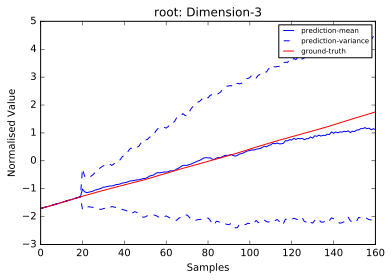

In [6]:
y_train = y_test_dict['root']
u_train = [np.ones((200,1)), np.ones((200,1)), np.ones((200,1)), np.ones((200,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 2)

Observationa dimension: 3
Control signal dimension: 6


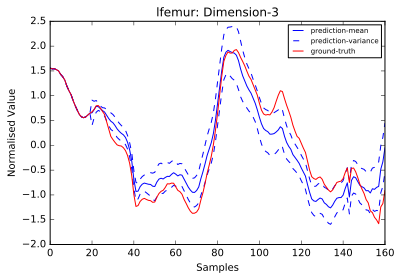

In [11]:
y = y_test_dict['lfemur']
u = y_test_dict['root']
pred_plot(0, 20, 20, 'lfemur', y, u, 2)

Observationa dimension: 2
Control signal dimension: 3


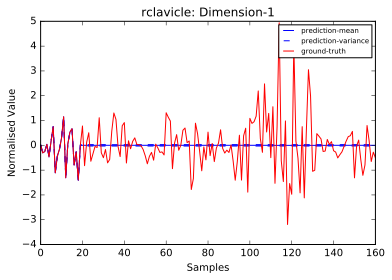

In [29]:
y = y_test_dict['rclavicle']
u = y_test_dict['thorax']
pred_plot(0, 20, 20, 'rclavicle', y, u, 0)

The values for this dimension has very high frequency compared to all other dimensions. This unusual feature causes the prediction to collapse to the prior. 

Observationa dimension: 1
Control signal dimension: 2


 /home/yw440/MXRGP/mxgpy/util.py:182: RuntimeWarning:invalid value encountered in greater


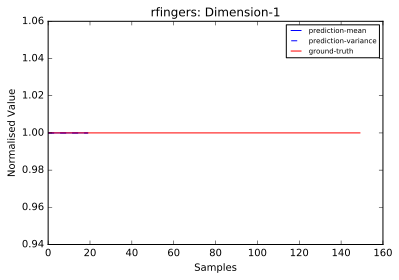

In [23]:
y = y_test_dict['rfingers']
u = y_test_dict['rhand']
pred_plot(0, 20, 20, 'rfingers', y, u, 0)

For fingers, the value is always constant. When comduct normalisation, the std is zero, there will occur nan values for this dimension after deviced by 0. This is the reason for false prediction.   

Observationa dimension: 1
Control signal dimension: 2


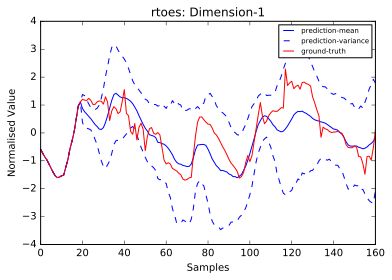

In [31]:
y = y_test_dict['rtoes']
u = y_test_dict['rfoot']
pred_plot(0, 20, 20, 'rtoes', y, u, 0)

In [5]:
y_train_list, y_test_list = [], []
for j, bone in enumerate(y_bones):  
#     print(str(j)+'-'+bone)
    y_train_list.append(y_train_dict[bone])
    y_test_list.append(y_test_dict[bone])
    if bone is 'root':
        u_train_list = [ [np.ones((np.shape(y_train[0][0])[0],1)),
                       np.ones((np.shape(y_train[0][1])[0],1)),
                       np.ones((np.shape(y_train[0][2])[0],1)),
                       np.ones((np.shape(y_train[0][3])[0],1))] ]
        
        u_test_list = [ [np.ones((np.shape(y_test[0][0])[0],1)),
                       np.ones((np.shape(y_test[0][1])[0],1)),
                       np.ones((np.shape(y_test[0][2])[0],1)),
                       np.ones((np.shape(y_test[0][3])[0],1))] ]
    else:
        u_train_list.append(y_train_dict[u_bones[j]])
        u_test_list.append(y_test_dict[u_bones[j]])
     

In [6]:
def test_run(model, seq, win_out, win_in, test_data, control_signal, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = 1 if model is 'root' else np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
    
        m = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, 
            num_inducing=100, kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
        m.load_params('../models/control_signal/run/'+model)
    
        y_pd = m.layers[0].freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                               U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [7]:
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

win_out = 20
win_in = 20
num_test_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print('===============  '+model+'   ================')
    for seq in range(num_test_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_test_list[i], u_test_list[i], MEAN_PRED=True, with_control=True) # output array
#         print(y_pd_temp.shape)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
#             print(y_pds[seq].shape)


===============  root   ================
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
===============  lfemur   ================
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
===============  ltibia   ================
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
===============  lfoot   ================
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimensio

 /home/yw440/MXRGP/mxgpy/util.py:182: RuntimeWarning:invalid value encountered in greater


Observationa dimension: 1
Control signal dimension: 2
Observationa dimension: 1
Control signal dimension: 2
Observationa dimension: 1
Control signal dimension: 2
===============  lthumb   ================
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
===============  rclavicle   ================
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
Observationa dimension: 2
Control signal dimension: 3
===============  rhumerus   ================
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
Observationa dimension: 3
Control signal dimension: 2
===============  rradius   ================
Observationa

In [21]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
## lfingers and rfingers have constant values therefore, goes to 0 after normalisation. 
## mannually add original values to the final predictions.
for i in range(4):
    pds[i][:,20:21] = y_test_list[20][i] #lfingers
    pds[i][:,-4:-3] = y_test_list[27][i] #rfingers
    
# print(y_train[20][3]) #lfingers original data
#print(y_train[27][2]) #lfingers original data
for seq, pd in enumerate(pds):
    filename = './predictions/fully_control/test_seq'+str(seq)
    helper.write_amc(pd, filename)


# Try free run exceeding training time!

Observationa dimension: 6
Control signal dimension: 1


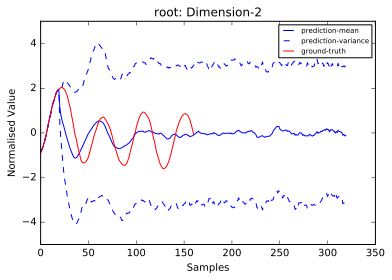

In [42]:
y_train = y_test_dict['root']
u_train = [np.ones((320,1)), np.ones((320,1)), np.ones((320,1)), np.ones((320,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 1, steps=300)

Observationa dimension: 6
Control signal dimension: 1


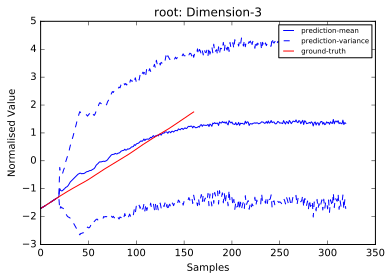

In [44]:
y_train = y_test_dict['root']
u_train = [np.ones((320,1)), np.ones((320,1)), np.ones((320,1)), np.ones((320,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 2, steps=300, WRITE_FIG=False)

The predictions becomes smooth very quickly after an initial short window! This creates problem for predictions exceeding training sequence length. 

Observationa dimension: 6
Control signal dimension: 1


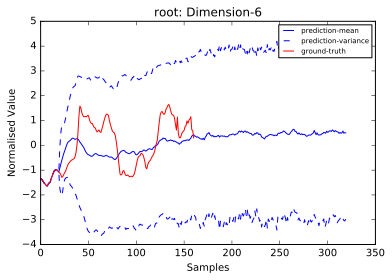

In [47]:
y_train = y_test_dict['root']
u_train = [np.ones((320,1)), np.ones((320,1)), np.ones((320,1)), np.ones((320,1))]
pred_plot(0, 20, 20, 'root', y_train, u_train, 5, steps=300, WRITE_FIG=False)

In [82]:
# Function to show 3D image of a human given the data as an array
def save_trail(data, skel, filename):
    import os
    import GPy
    a = np.zeros((62,))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=10., azim=15)
#     ax.axis([-10,10,-10,150])
#     help(ax.axis)
    
    ax.set_xlim3d([-10, 10])
    ax.set_zlim3d([-20, 20])
    ax.set_ylim3d([-10, 140])
    
    for i in range(13):
        a[3:] = data[i*8]
        a[2] = i*12
        p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
        
    plt.show()
    fig.savefig(filename)


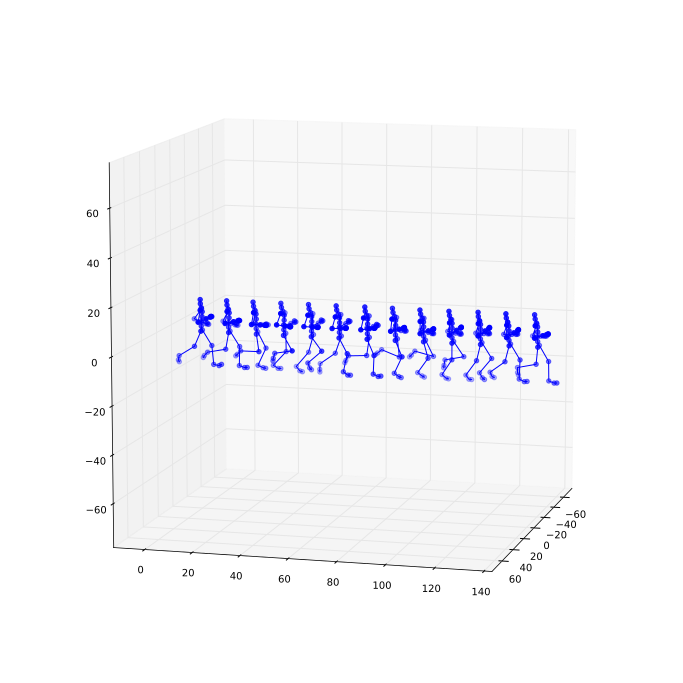

In [83]:
seq = 1

data = pds[seq][:,3:] #reverse normalised
save_trail(data, m1['skel'], 'run_seq0')

In [24]:
pds[1][10]

array([-4.12618e-01,  1.74627e+01, -3.06000e+01,  4.30118e+00,
       -7.92120e+00, -1.07199e+00,  2.88987e+00,  2.95270e+00,
       -2.32995e+01,  7.63677e+01,  3.92322e+01, -2.06715e+01,
        7.30752e+00, -3.78475e+01,  6.98272e-01,  2.95667e+01,
        4.04390e+01, -4.78598e+00,  2.63540e+00,  6.63506e+00,
        1.00000e+00, -4.29233e-01, -5.81188e-01, -1.46683e-01,
       -4.71058e-01,  2.21758e+00, -9.50058e+00, -1.38145e-01,
        2.85149e+00, -1.75021e+01, -1.85041e+00, -3.09500e+00,
        1.30230e+01, -2.02302e+00,  1.70923e+00,  6.89635e+00,
       -9.74134e-01,  8.36707e-01,  4.17448e-15,  5.16840e-15,
       -4.37785e+01, -1.02449e+01,  9.54579e+01,  1.07672e+02,
        3.57057e+01, -2.57491e+01,  6.21917e-01,  7.12502e+00,
        7.88047e-01,  3.06002e+01,  4.17448e-15,  5.16840e-15,
       -5.80665e+01,  3.58796e+00, -9.05130e+01,  1.00403e+02,
       -1.26777e+01, -2.11138e+01,  1.00000e+00,  7.12502e+00,
        5.26448e+00,  1.15495e+01])